In [ ]:
#!pip install tensorflow==2.6.0

In [ ]:
from google.colab import files
from google_drive_downloader import GoogleDriveDownloader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch 
import os
import tqdm
import tensorflow as tf
import pandas as pd
import albumentations as A
import cv2
import torchvision
import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import torch.nn as nn
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

Deixando o dataset pronto pra uso



In [ ]:
images_path = Path('/content/drive/MyDrive/IA/IMG/bacteria/images')
masks_path = Path('/content/drive/MyDrive/IA/IMG/bacteria/masks')

images = list(images_path.glob(r'*.png')) # creates a list with every image
masks = list(masks_path.glob(r'*.png')) # creates a list with every mask
print(images)
images = pd.Series(images, name = 'images').sort_values() # converting the list into a Series object and using sort_values() to organize it in crescent order
masks = pd.Series(masks, name = 'masks').sort_values()

images.reset_index(drop = True, inplace = True) #reset the index because even after you sort the elements in a Series object the index will remain the same
masks.reset_index(drop = True, inplace = True)

dataset = pd.concat([images, masks], axis =1) #unifying masks and images in a unique Dataframe


[PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/003.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/001.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/002.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/008.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/006.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/016.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/017.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/011.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/019.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/012.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/013.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/020.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/015.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacteria/images/014.png'), PosixPath('/content/drive/MyDrive/IA/IMG/bacter

Suport reading function

In [ ]:
def read(path):
  array = cv2.imread(str(path))
  array = cv2.cvtColor(array, cv2.COLOR_BGR2RGB)
  return array


Checking out our new Dataframe

In [ ]:
dataset

,images,masks
0,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/0...
1,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/0...
2,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/0...
3,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/0...
4,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/0...
...,...,...
361,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/3...
362,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/3...
363,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/3...
364,/content/drive/MyDrive/IA/IMG/bacteria/images/...,/content/drive/MyDrive/IA/IMG/bacteria/masks/3...


Checking the shape of the images




In [ ]:

for i in range(10):
  print(read(dataset.images.iloc[i]).shape)
 



(720, 710, 3)
(1076, 1406, 3)
(1078, 1402, 3)
(1080, 1020, 3)
(1080, 848, 3)
(1080, 880, 3)
(1080, 880, 3)
(1080, 924, 3)
(1080, 1154, 3)
(1070, 1066, 3)


Resizing images and masks

In [ ]:
resized_imgs = []
resized_masks = []
for image, mask in zip(dataset.images, dataset.masks): #zip function creates a iterable object, to create a dic type: list(zip_object)
  image_resized = cv2.resize(read(image), (256,256))
  mask_resized = cv2.resize(read(mask), (256,256))

  resized_imgs.append(image_resized)
  resized_masks.append(mask_resized)
print(len(resized_imgs))
print(len(resized_masks))

366
366


taking only the mask that identify bacterias

In [ ]:
masks = np.array(resized_masks)
new_masks = []
for i in range(len(masks)):
  new_mask = np.equal(masks[i],2)*1 #keeping only values equal to 2 in the image
  new_masks.append(np.array(new_mask))  
#new_masks = np.array(new_masks)  

Cropping images and masks

In [ ]:
new_imgs_crop = []
new_masks_crop = []
for img,mask in zip(resized_imgs, resized_masks):
  for i in range(1,3):
    for j in range(1,3):
      init0 = 128*(i-1)
      end0 = 128*i
      init1 = 128*(j-1)
      end1 = 128*j
      new_img = img[init0:end0, init1:end1 ,:]
      new_mask = mask[init0:end0, init1:end1 ,:]
      new_imgs_crop.append(new_img)
      new_masks_crop.append(new_mask[:,:,0])
      #plt.imshow(new_img[:,:,0])
      #plt.show()
      #plt.imshow(new_mask[:,:,0])
      #plt.show()
new_imgs_crop = np.array(new_imgs_crop)
new_masks_crop = np.array(new_masks_crop)      

Exploring the masks

[0 1]
(256, 256, 3)
(256, 256, 3)


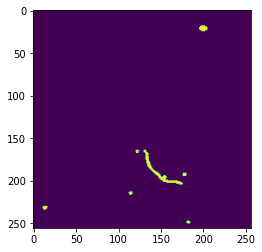

In [ ]:
print(np.unique(new_masks[5])) #how many diferent values there are in the image matrix
print(masks[5].shape)
print(new_masks[5].shape)
plt.imshow(new_masks[5][:,:,0])

In [ ]:
print(new_imgs_crop.shape)
print(new_masks_crop.shape)
new_masks_crop = new_masks_crop.reshape((new_masks_crop.shape[0], new_masks_crop.shape[1], new_masks_crop.shape[2],1))
#new_imgs_crop = new_imgs_crop.reshape((new_imgs_crop.shape[0], new_imgs_crop.shape[1], new_imgs_crop.shape[2],1))
print(new_imgs_crop.shape)
print(new_masks_crop.shape)

(1464, 128, 128, 3)
(1464, 128, 128)
(1464, 128, 128, 3)
(1464, 128, 128, 1)


In [ ]:
size = new_imgs_crop.shape[0]
train_imgs = new_imgs_crop[:int(size*0.95)]
train_masks = new_masks_crop[:int(size*0.95)]

test_imgs = new_imgs_crop[int(size*0.95):]
test_masks = new_masks_crop[int(size*0.95):]

In [ ]:
print(train_imgs.shape)
print(train_masks.shape)
print(test_imgs.shape)
print(test_masks.shape)

(1390, 128, 128, 3)
(1390, 128, 128, 1)
(74, 128, 128, 3)
(74, 128, 128, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical
train_masks_categorical = to_categorical(train_masks, num_classes = 3)
test_masks_categorical = to_categorical(test_masks, num_classes = 3)


In [ ]:
print(train_imgs.shape)
print(train_masks_categorical.shape)
print(test_imgs.shape)
print(test_masks_categorical.shape)


(1390, 128, 128, 3)
(1390, 128, 128, 3)
(74, 128, 128, 3)
(74, 128, 128, 3)


In [ ]:
#plt.imshow(test_masks[0])
#np.unique(train_masks_categorical[3])

In [ ]:
from keras.models import Model
from keras import activations

In [ ]:
print(train_masks[0].shape)
np.unique(train_masks[2])

(128, 128, 1)


array([0, 1, 2], dtype=uint8)

preprocessing


In [ ]:
layers = tf.keras.layers
model = tf.keras.models.Sequential()
  #encoder
def model(filters_number):  

  n = (3,3)
  input = layers.Input((128,128,3))
  l1 = layers.Rescaling(1./255)(input)
  #l2 = layers.RandomFlip("horizontal_and_vertical")(l1)
  #l4 = layers.RandomRotation(0.2)(l2)
  l4 = layers.RandomContrast(0.4)(l1)
  #print(input)
  c1 = layers.Conv2D(filters_number, n, activation = 'relu',padding = 'same', input_shape = input.shape )(l4)
  print(c1)
  c1 = layers.Conv2D(filters_number, n,activation = 'relu',padding = 'same')(c1)
  print(c1)
  m1 = layers.MaxPooling2D(pool_size = (2,2))(c1)
  m1 = layers.Dropout(0.25)(m1)

  c2 = layers.Conv2D(filters_number*2, n, padding = 'same',activation = 'relu')(m1)
  print(c2)  
  c2 = layers.Conv2D(filters_number*2, n,padding = 'same', activation = 'relu')(c2)
  print(c2)
  m2 = layers.MaxPooling2D(pool_size = (2,2))(c2)
  m2 = layers.Dropout(0.5)(m2)

  c3 = layers.Conv2D(filters_number*4, n, padding = 'same',activation = 'relu')(m2)
  print(c3)
  c3 = layers.Conv2D(filters_number*4, n,padding = 'same', activation = 'relu')(c3)
  print(c3)
  m3 = layers.MaxPooling2D(pool_size = (2,2))(c3)
  m3 = layers.Dropout(0.5)(m3)

  c4 = layers.Conv2D(filters_number*8, n, padding = 'same',activation = 'relu')(m3)
  print(c4)
  c4 = layers.Conv2D(filters_number*8, n,padding = 'same', activation = 'relu')(c4)
  print(c4)
  m4 = layers.MaxPooling2D(pool_size = (2,2))(c4)
  m4 = layers.Dropout(0.5)(m4)

  c5 = layers.Conv2D(filters_number*16, n, padding = 'same',activation = 'relu')(m4)
  print(c5)
  c5 = layers.Conv2D(filters_number*16, n,padding = 'same', activation = 'relu')(c5)
  print(c5)

  d20 = layers.Conv2DTranspose(filters_number*8,n, strides=(2,2), padding = 'same', activation='relu')(c5)
  print(d20)
  u1 = layers.concatenate([d20, c4])
  u1 = layers.Dropout(0.5)(u1)
  c50 = layers.Conv2D(filters_number*8, n, padding = 'same',activation = 'relu')(u1)
  c60 = layers.Conv2D(filters_number*8, n,padding = 'same', activation = 'relu')(c50)
  #c70 = layers.Conv2D(filters_number*8, n,padding = 'same', activation = 'relu')(c60)

  d21 = layers.Conv2DTranspose(filters_number*4, n, strides=(2,2), padding = 'same', activation='relu')(c60)
  u2 = layers.concatenate([d21, c3])
  u2 = layers.Dropout(0.5)(u2)
  c70 = layers.Conv2D(filters_number*4, n, padding = 'same',activation = 'relu')(u2)
  c80 = layers.Conv2D(filters_number*4, n,padding = 'same', activation = 'relu')(c70)

  d22 = layers.Conv2DTranspose(filters_number*2,n, strides=(2,2), padding = 'same', activation='relu')(c80)
  u3 = layers.concatenate([d22, c2])
  u3 = layers.Dropout(0.5)(u3)
  c90 = layers.Conv2D(filters_number*2, n, padding = 'same',activation = 'relu')(u3)
  c100 = layers.Conv2D(filters_number*2, n,padding = 'same', activation = 'relu')(c90)

  d23 = layers.Conv2DTranspose(filters_number*1,n, strides=(2,2), padding = 'same', activation='relu')(c100)
  u4 = layers.concatenate([d23, c1])
  u4 = layers.Dropout(0.5)(u4)
  c110 = layers.Conv2D(filters_number*1, n, padding = 'same',activation = 'relu')(u4)
  c120 = layers.Conv2D(filters_number*1, n,padding = 'same', activation = 'relu')(c110)

  output = layers.Conv2D(3, n, padding = 'same', activation='softmax')(c120)

  return Model(inputs=input, outputs=output)
    #decoder




In [ ]:
filters_number = 32
model = model(filters_number)
#model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='conv2d_19/Relu:0', description="created by layer 'conv2d_19'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='conv2d_20/Relu:0', description="created by layer 'conv2d_20'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv2d_21/Relu:0', description="created by layer 'conv2d_21'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 64, 64), dtype=tf.float32, name=None), name='conv2d_22/Relu:0', description="created by layer 'conv2d_22'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='conv2d_23/Relu:0', description="created by layer 'conv2d_23'")
KerasTensor(type_spec=TensorSpec(shape=(None, 32, 32, 128), dtype=tf.float32, name=None), name='conv2d_24/Relu:0', description="created by layer 'conv2d_24'")
KerasTensor(type_spec=TensorSpec(shape=(None, 

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)#, momentum=0.7)
metric = tf.keras.metrics.MeanIoU(3, name=None, dtype= None)
model.compile(optimizer= optimizer, loss = loss ,metrics=metric)

In [ ]:
Checkpoint_Model = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                      save_best_only=True,    
                                                      save_weights_only=True,
                                                      filepath="./modelcheck")

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=40, verbose=1)


In [ ]:
model.fit(x = train_imgs, y = train_masks_categorical, validation_data = (test_imgs,test_masks_categorical), batch_size=15,  epochs=70,  callbacks=[Checkpoint_Model, lr_reduce]) #class_weight=class_weights) 


Epoch 1/70
93/93 [==============================] - 28s 276ms/step - loss: 0.3848 - mean_io_u_1: 0.3333 - val_loss: 0.2537 - val_mean_io_u_1: 0.3333 - lr: 0.0020
Epoch 2/70
93/93 [==============================] - 21s 227ms/step - loss: 0.2691 - mean_io_u_1: 0.3333 - val_loss: 0.2435 - val_mean_io_u_1: 0.3333 - lr: 0.0020
Epoch 3/70
93/93 [==============================] - 21s 221ms/step - loss: 0.2263 - mean_io_u_1: 0.3338 - val_loss: 0.1964 - val_mean_io_u_1: 0.3333 - lr: 0.0020
Epoch 4/70
93/93 [==============================] - 20s 220ms/step - loss: 0.1892 - mean_io_u_1: 0.3336 - val_loss: 0.1630 - val_mean_io_u_1: 0.3334 - lr: 0.0020
Epoch 5/70
93/93 [==============================] - 21s 222ms/step - loss: 0.1453 - mean_io_u_1: 0.3343 - val_loss: 0.1467 - val_mean_io_u_1: 0.3339 - lr: 0.0020
Epoch 6/70
93/93 [==============================] - 20s 218ms/step - loss: 0.1331 - mean_io_u_1: 0.3383 - val_loss: 0.1494 - val_mean_io_u_1: 0.3342 - lr: 0.0020
Epoch 7/70
93/93 [==========

In [ ]:
test_imgs.shape

(74, 128, 128, 3)

Prediction visualization

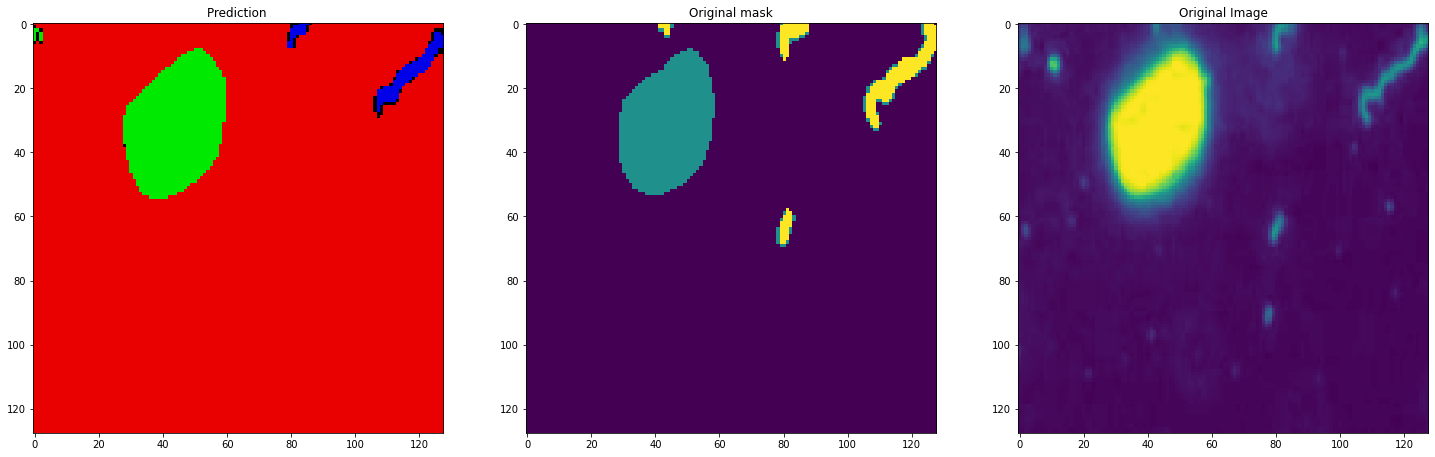

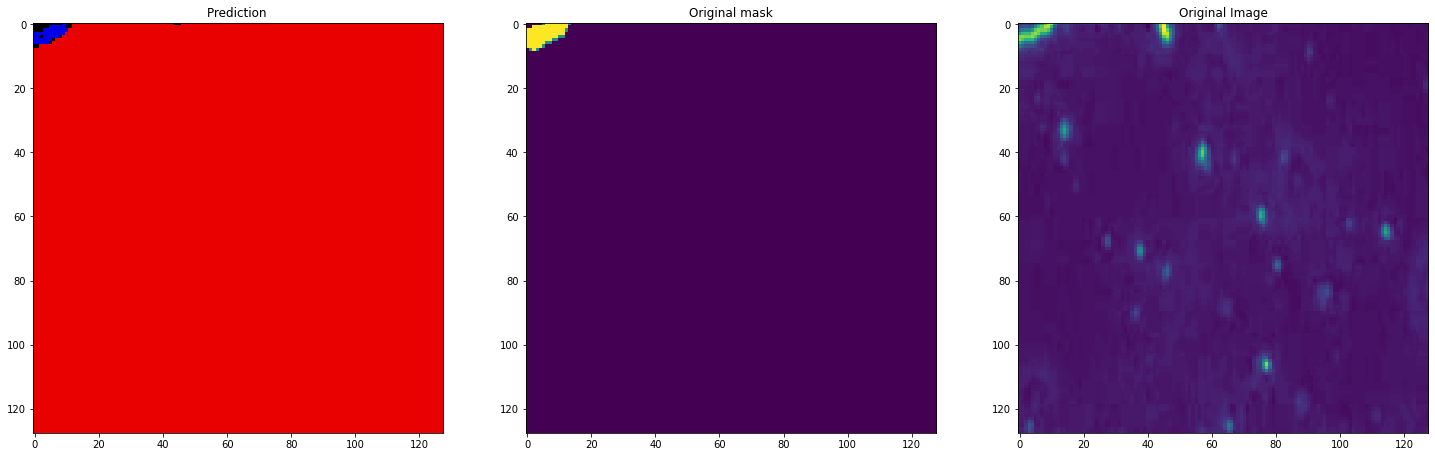

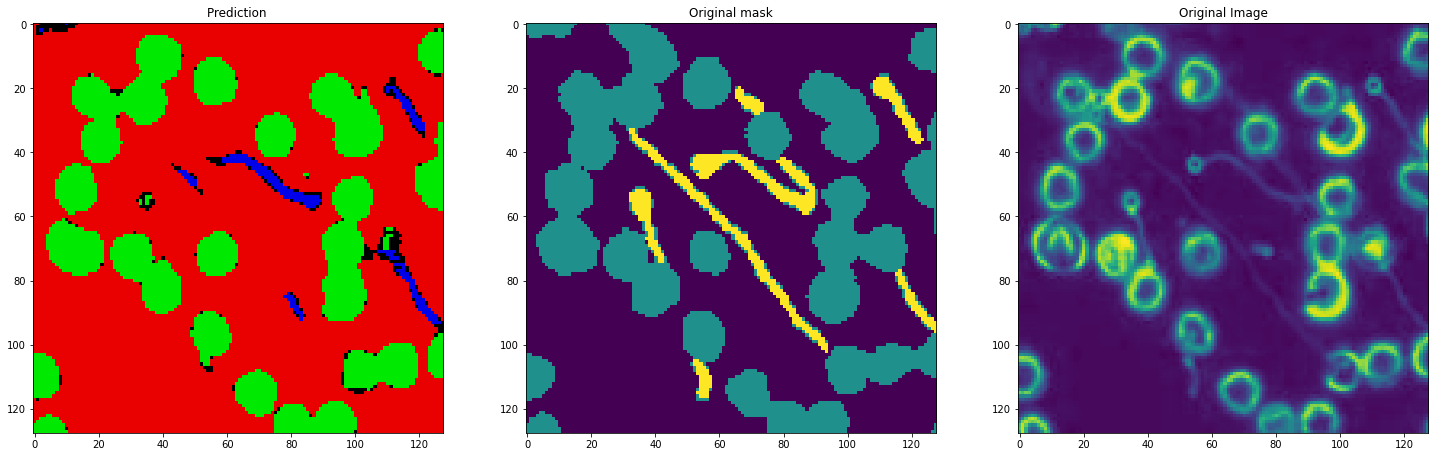

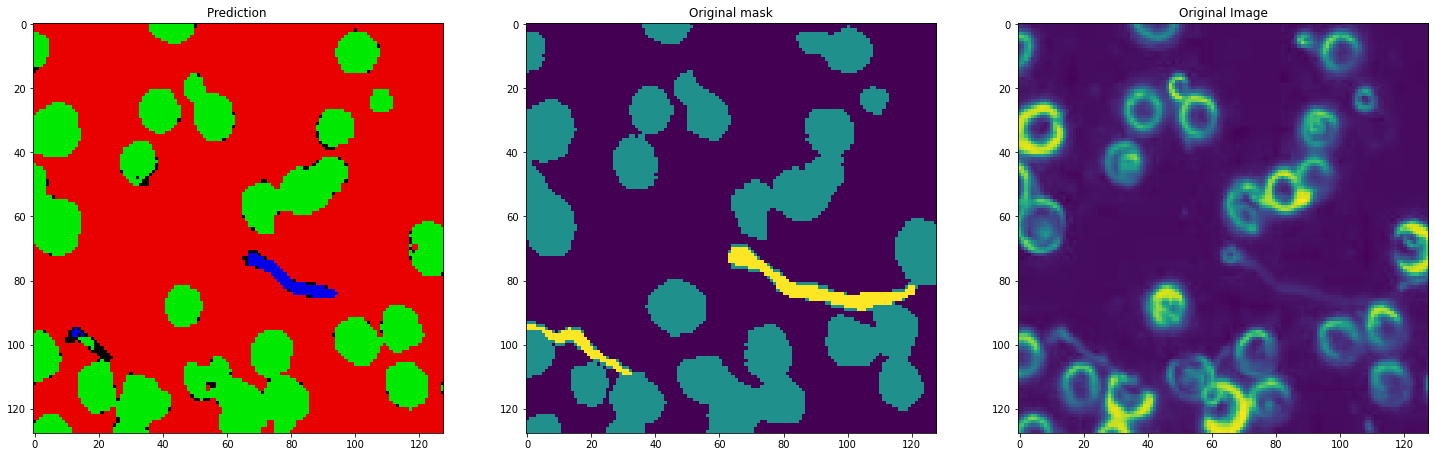

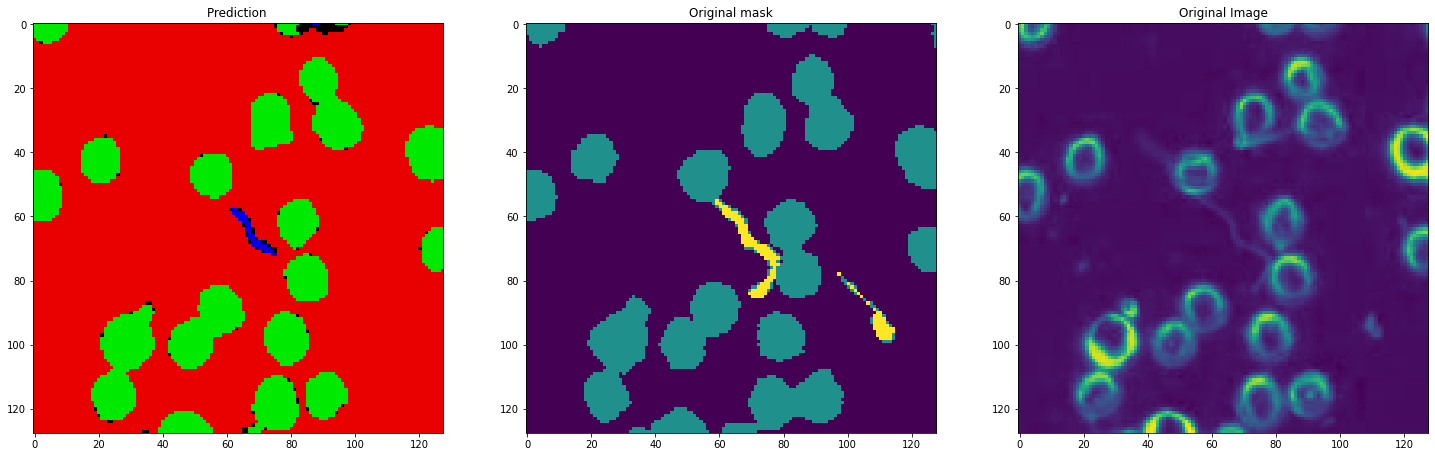

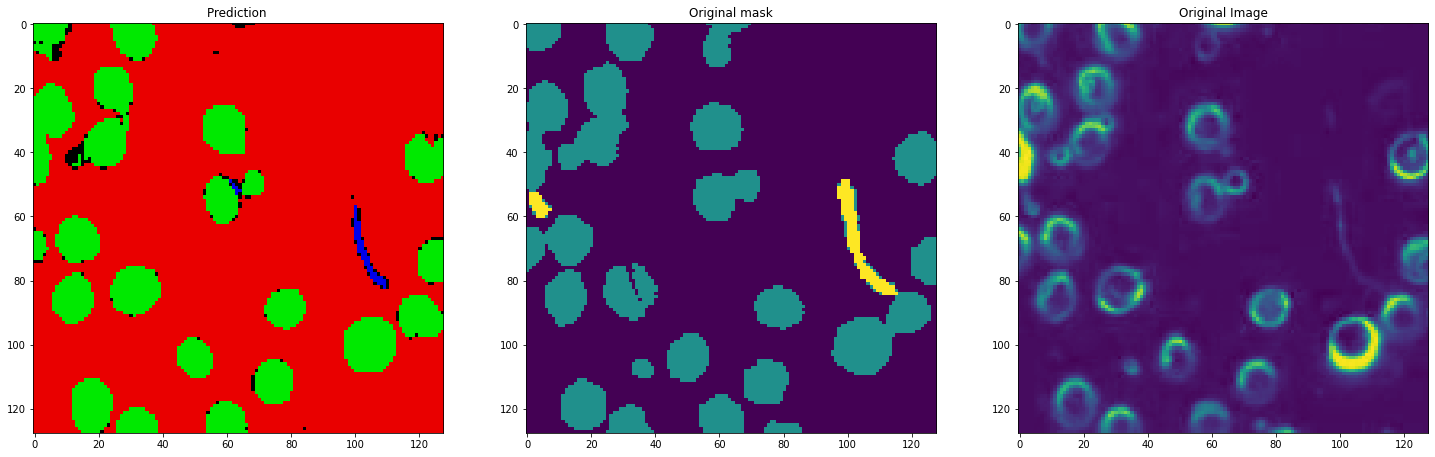

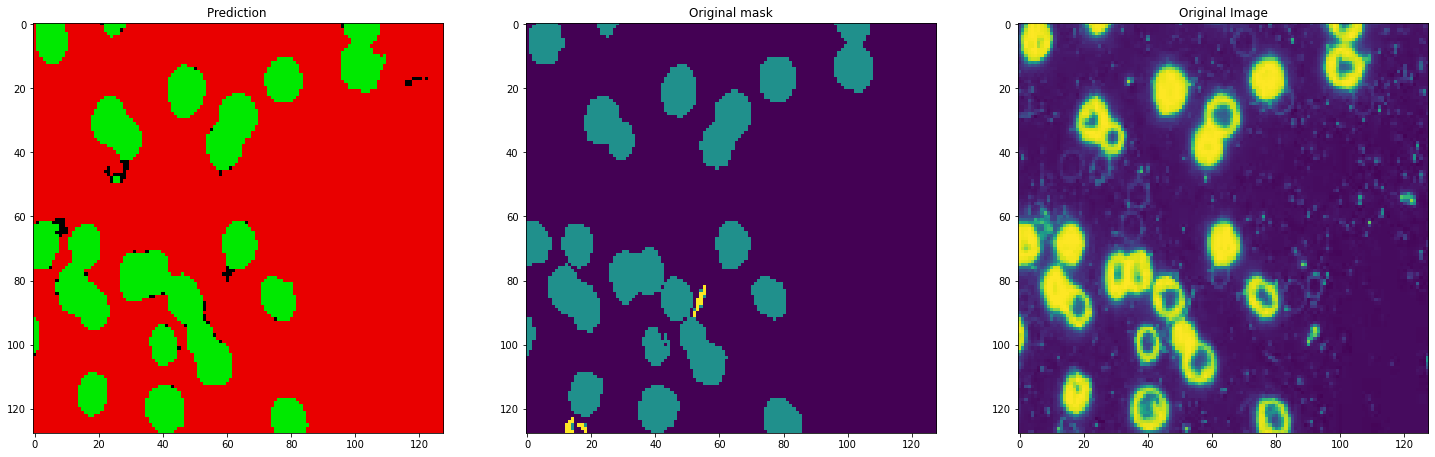

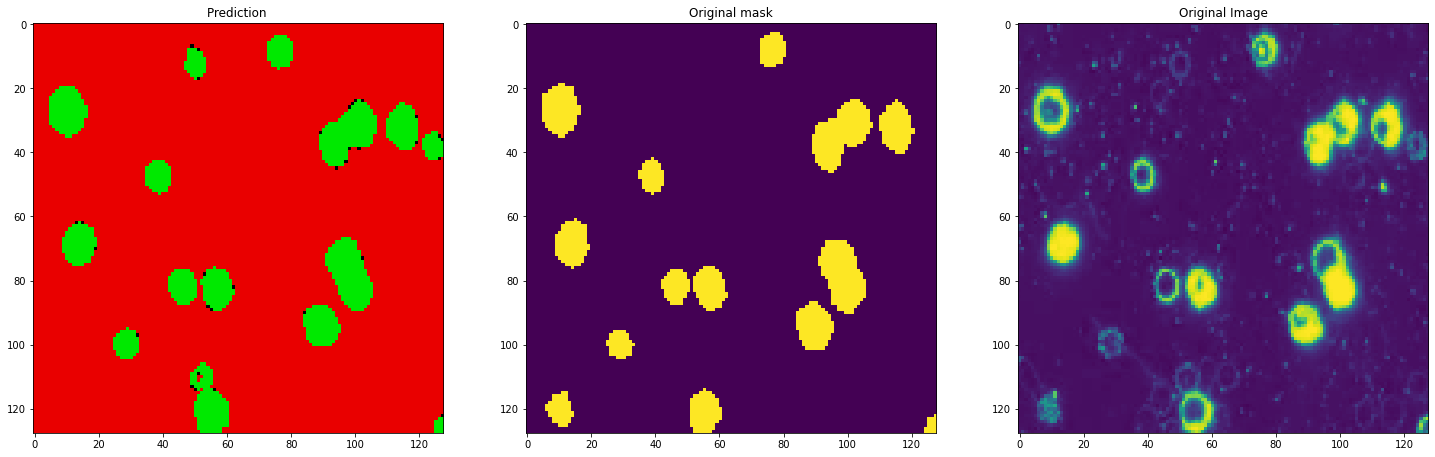

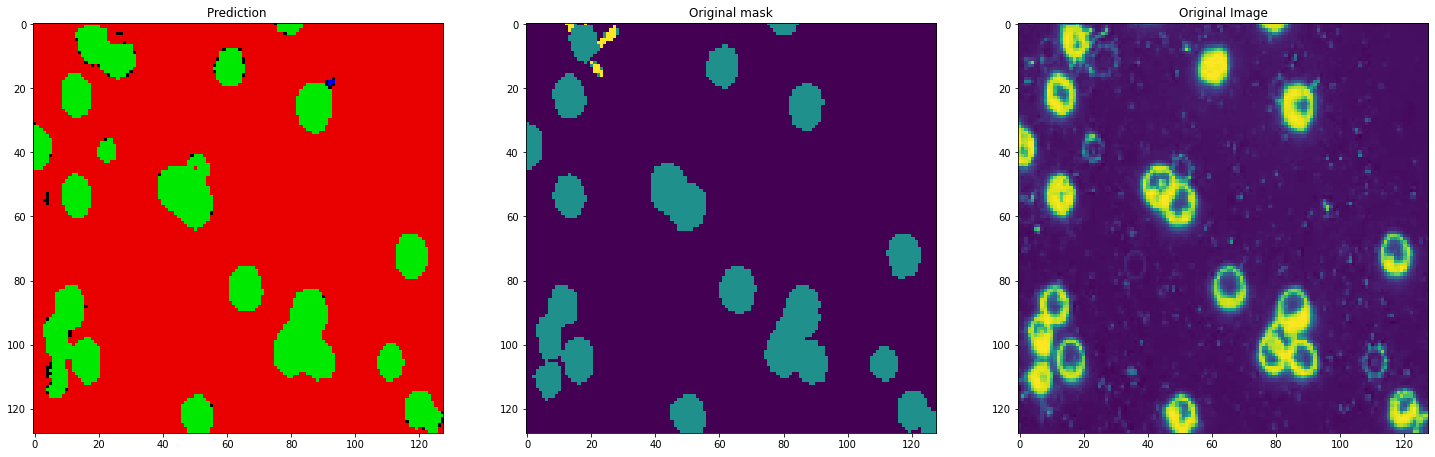

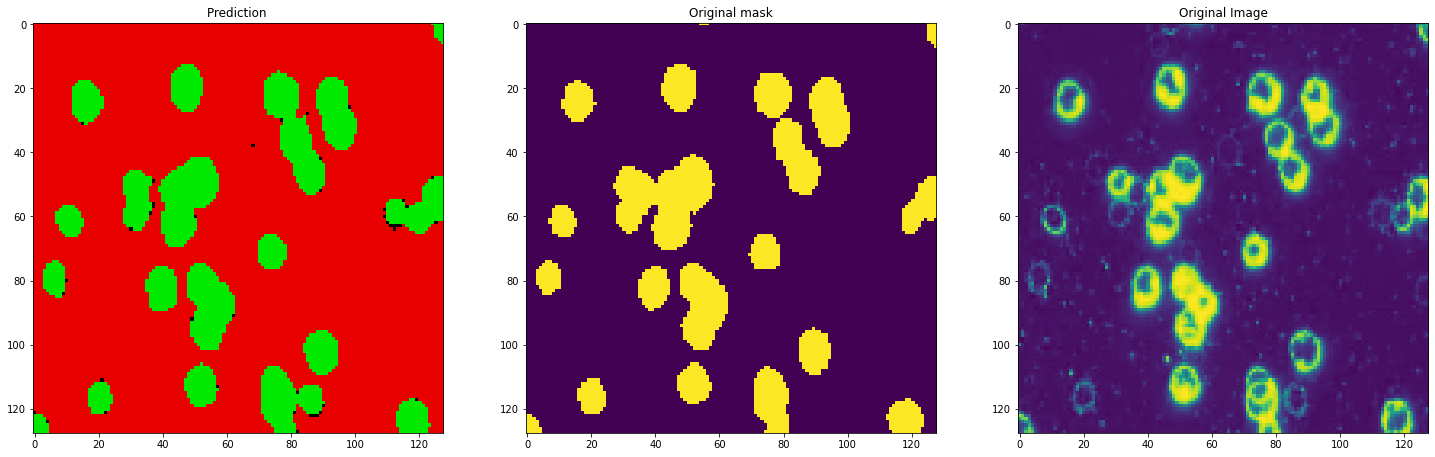

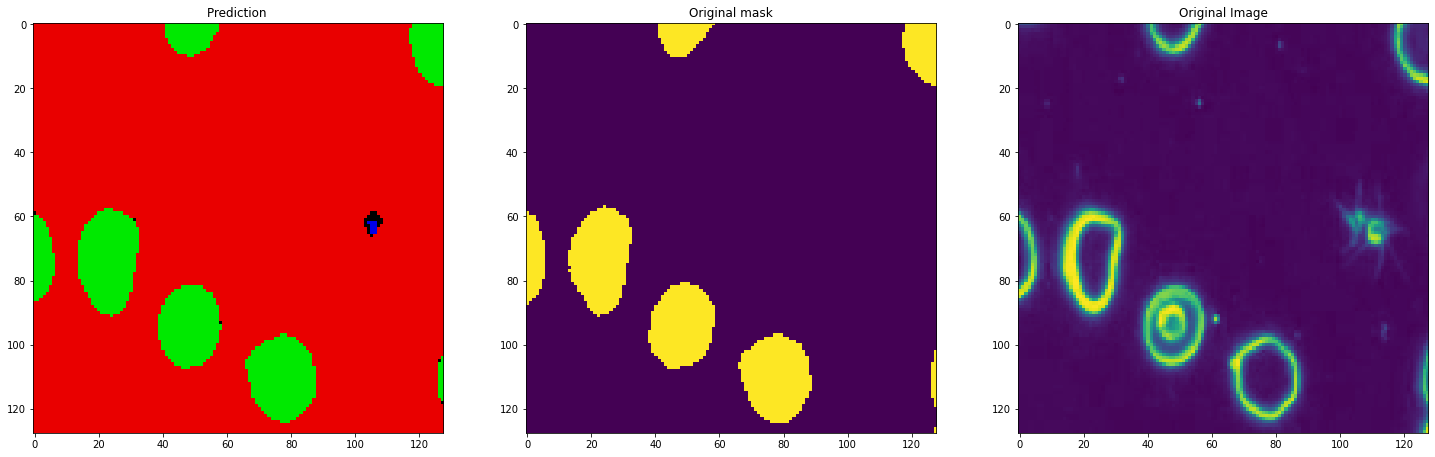

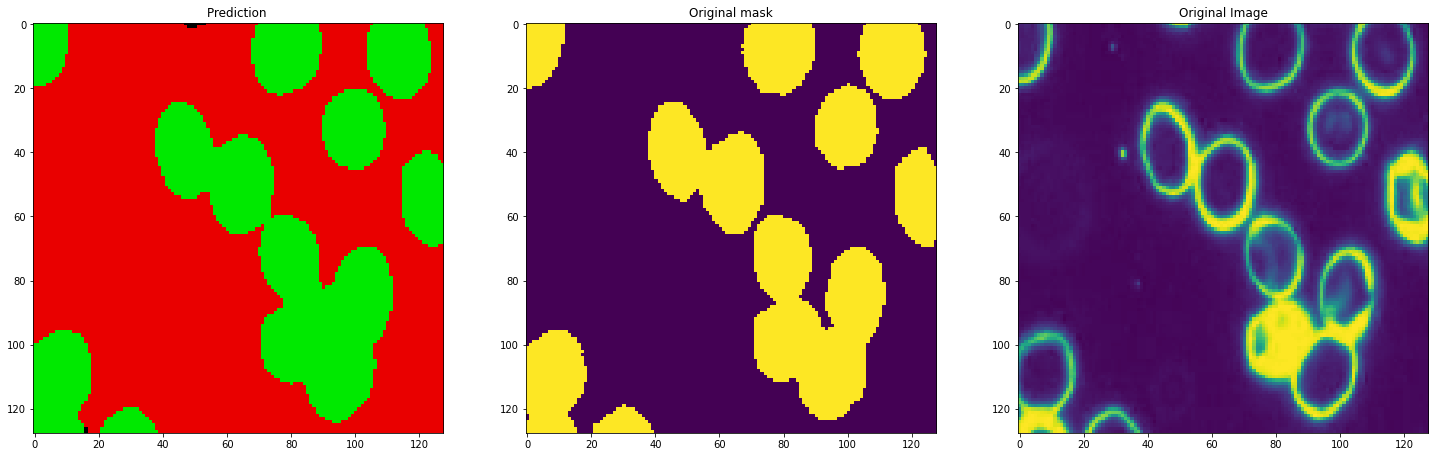

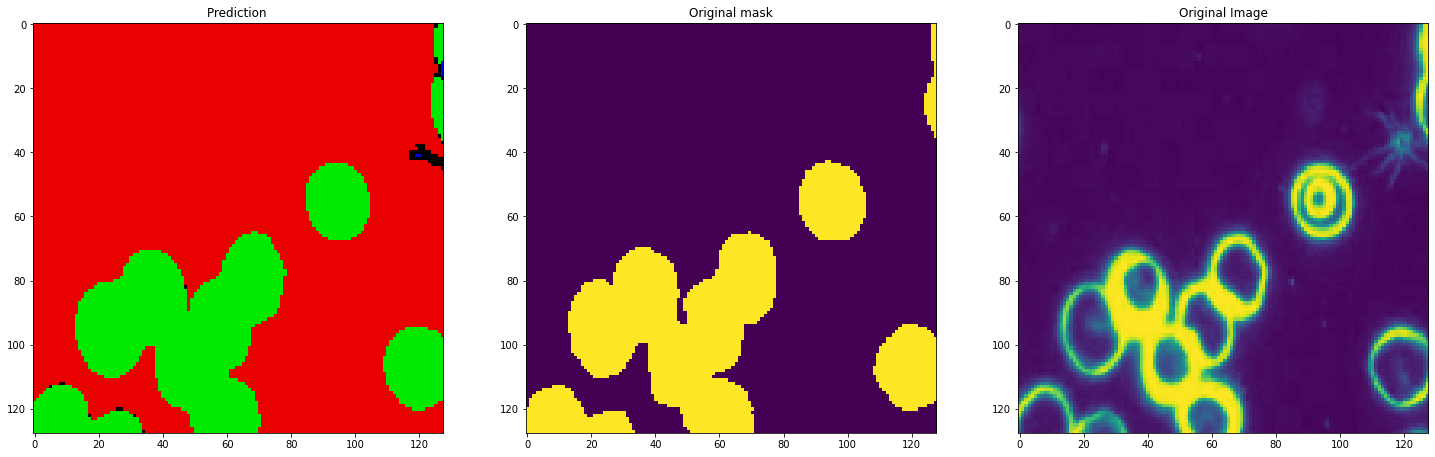

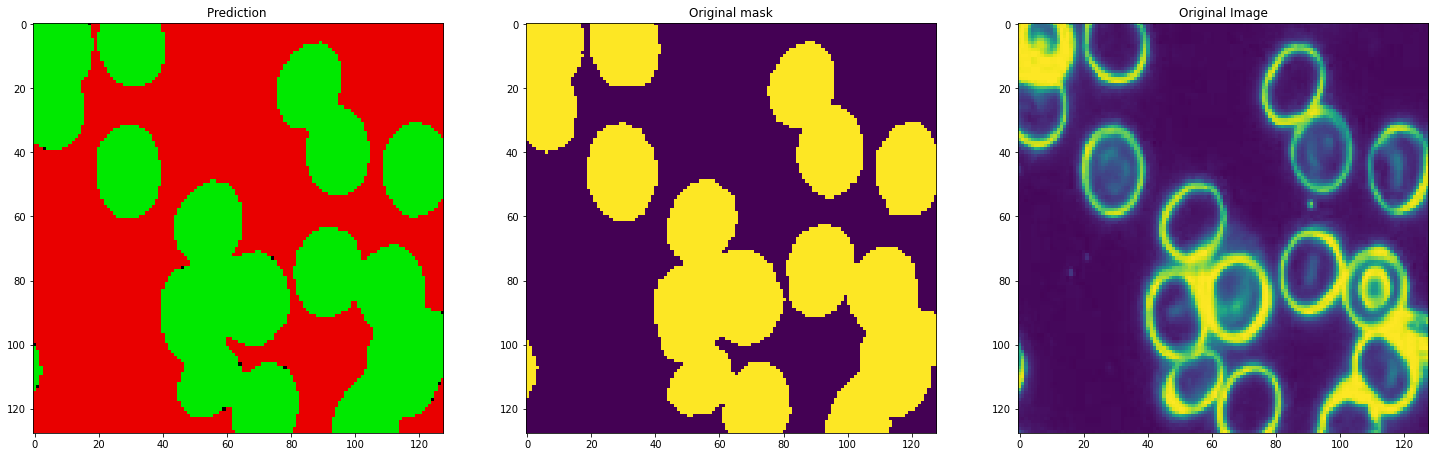

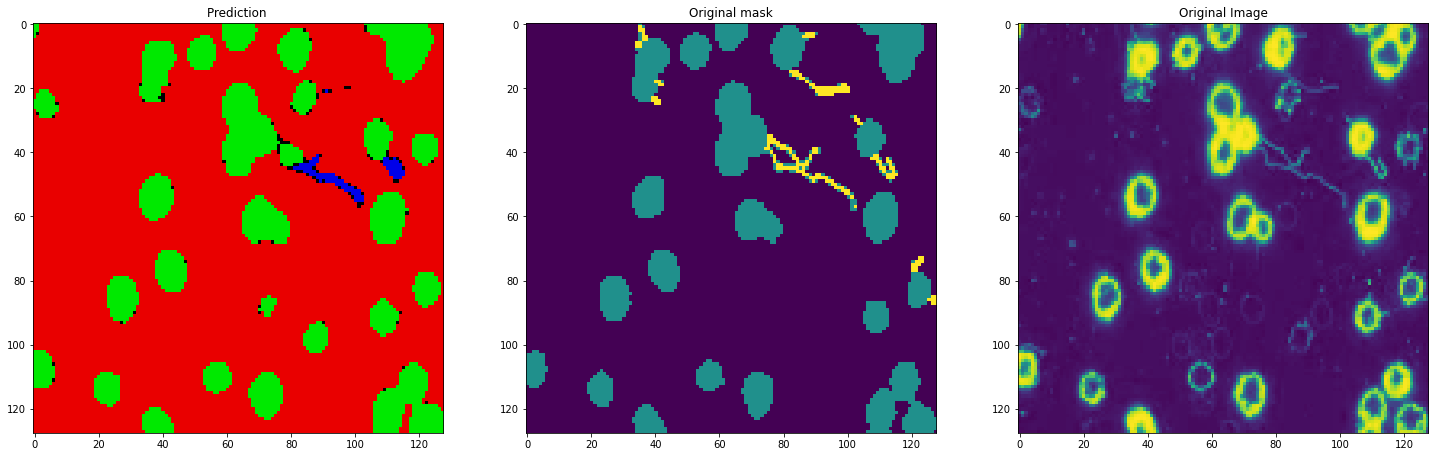

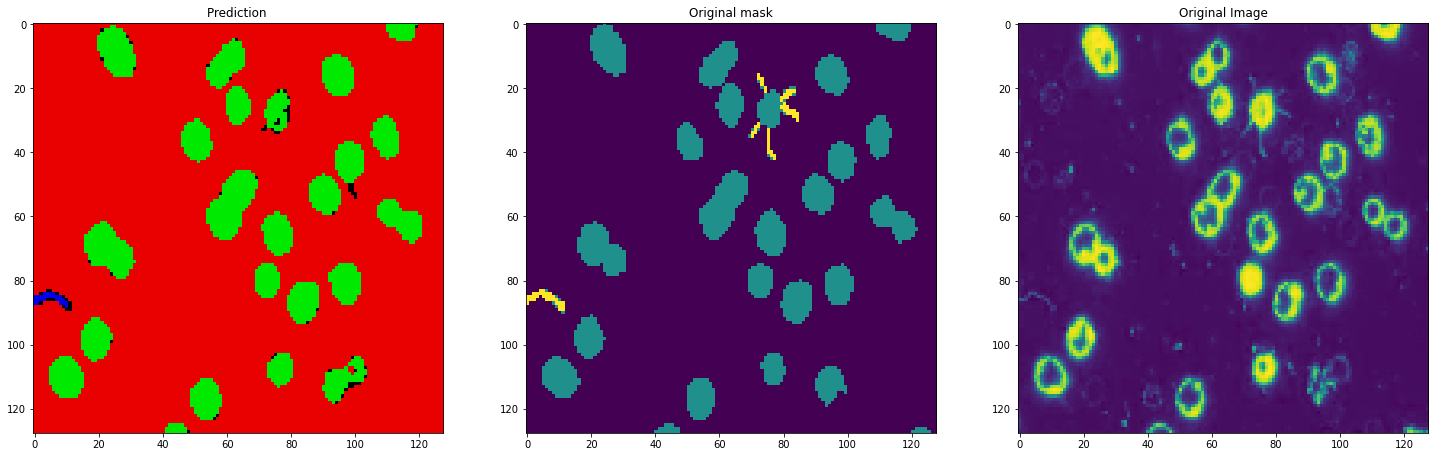

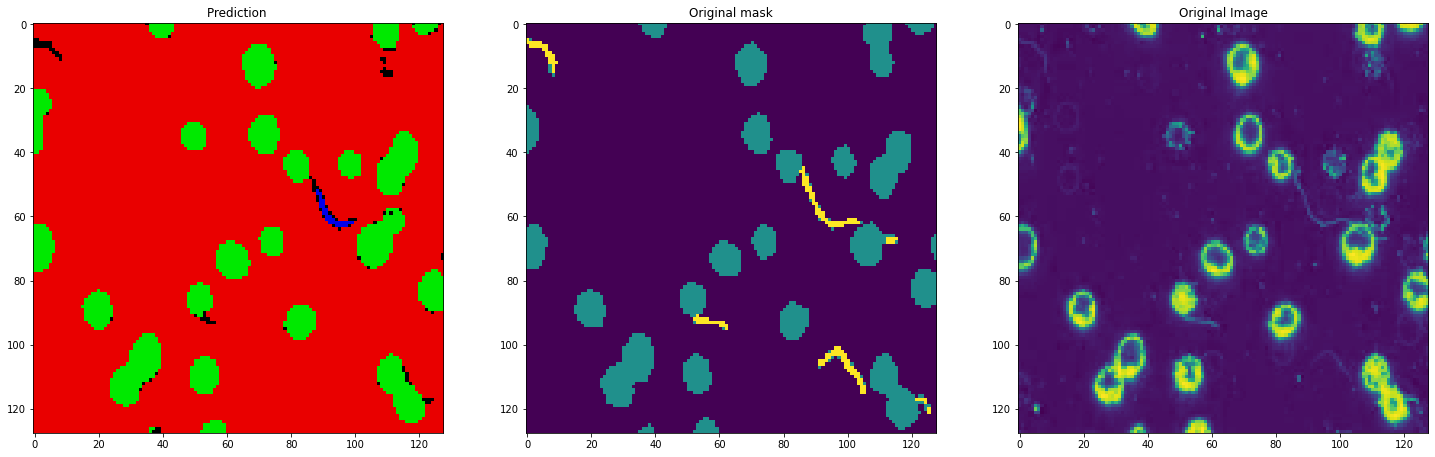

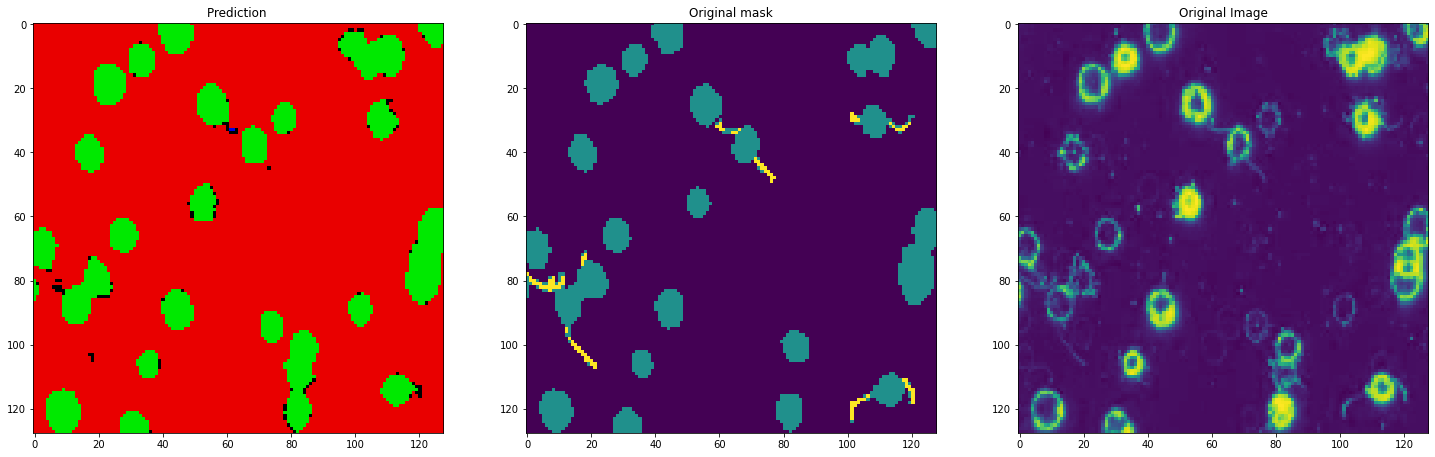

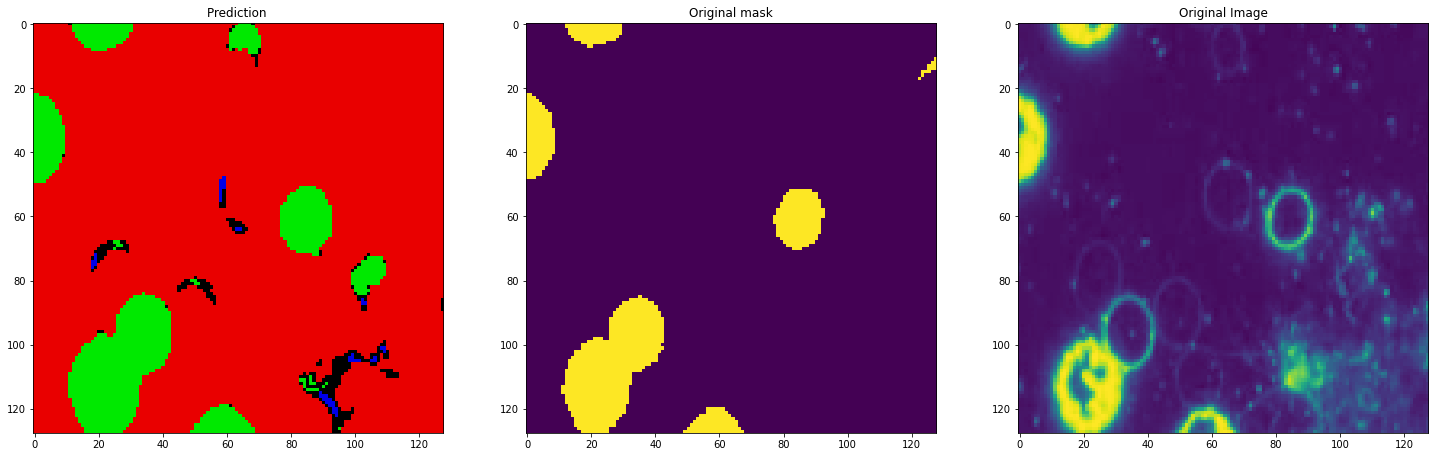

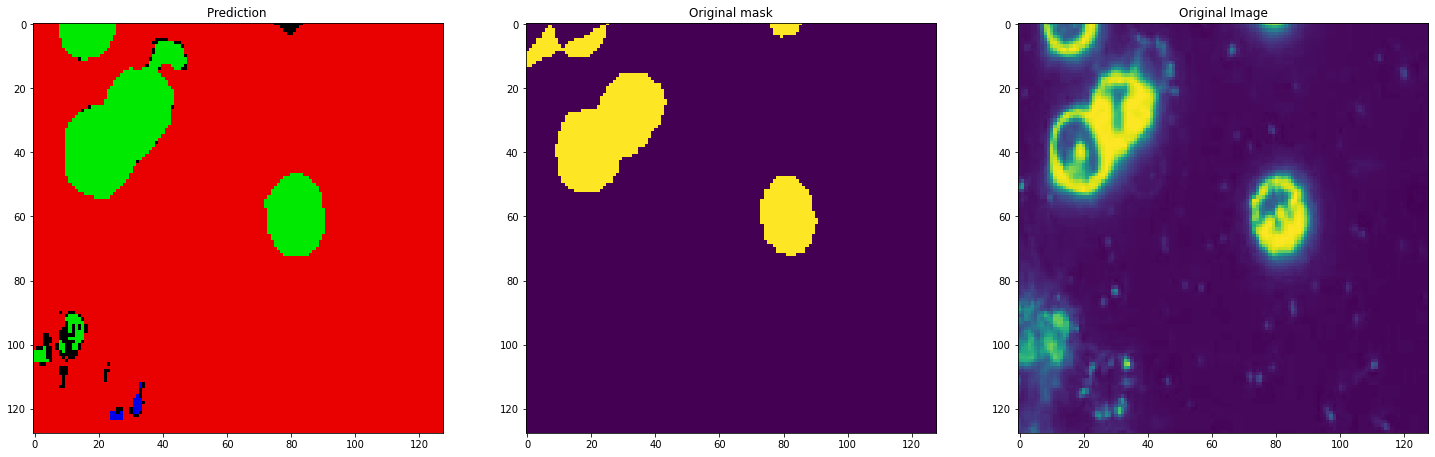

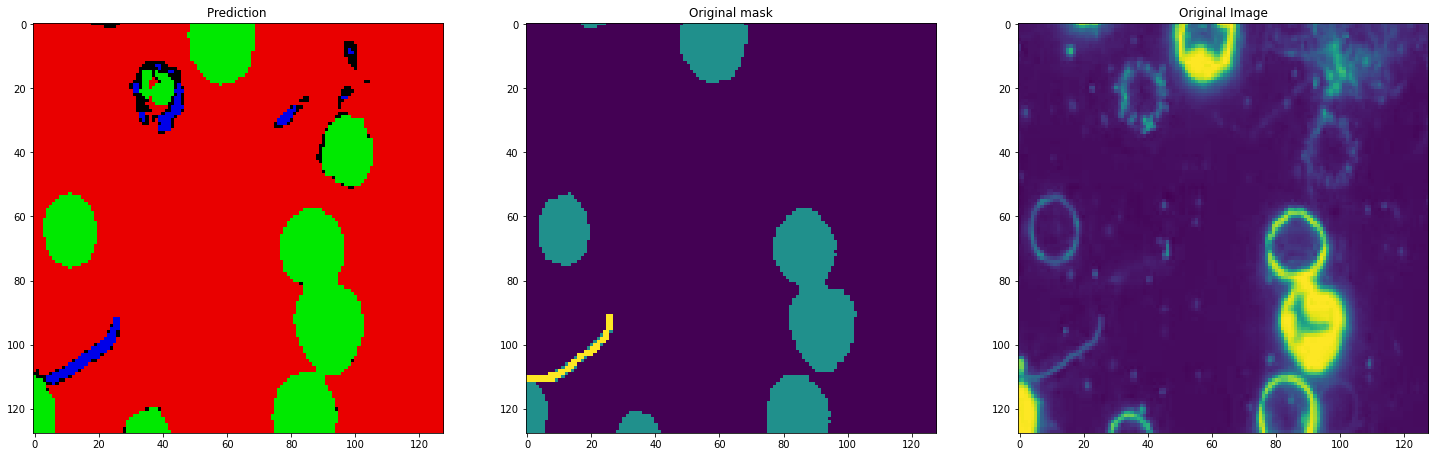

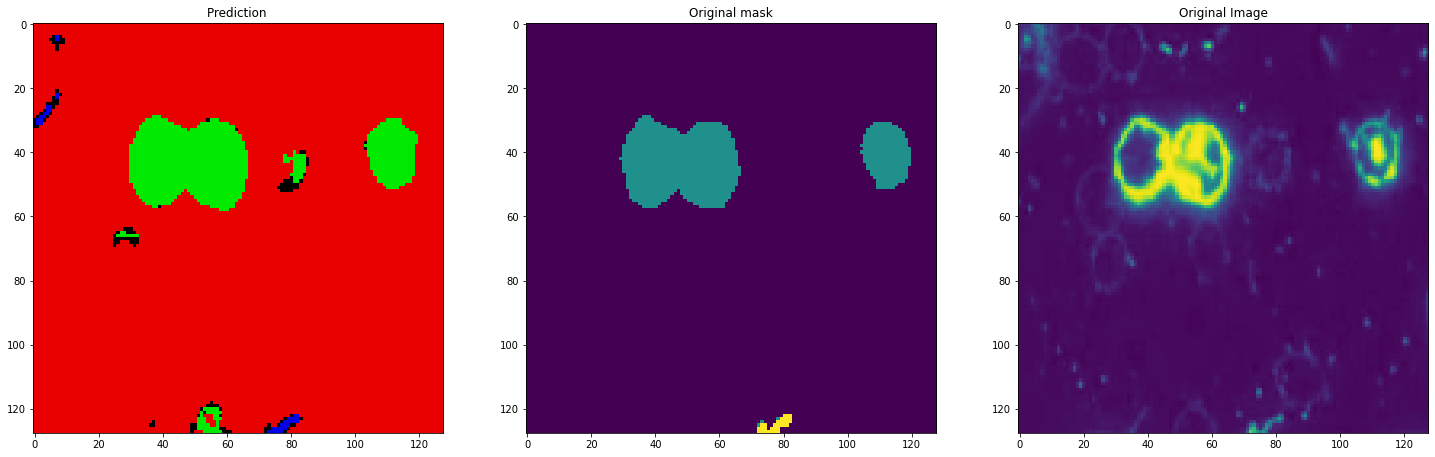

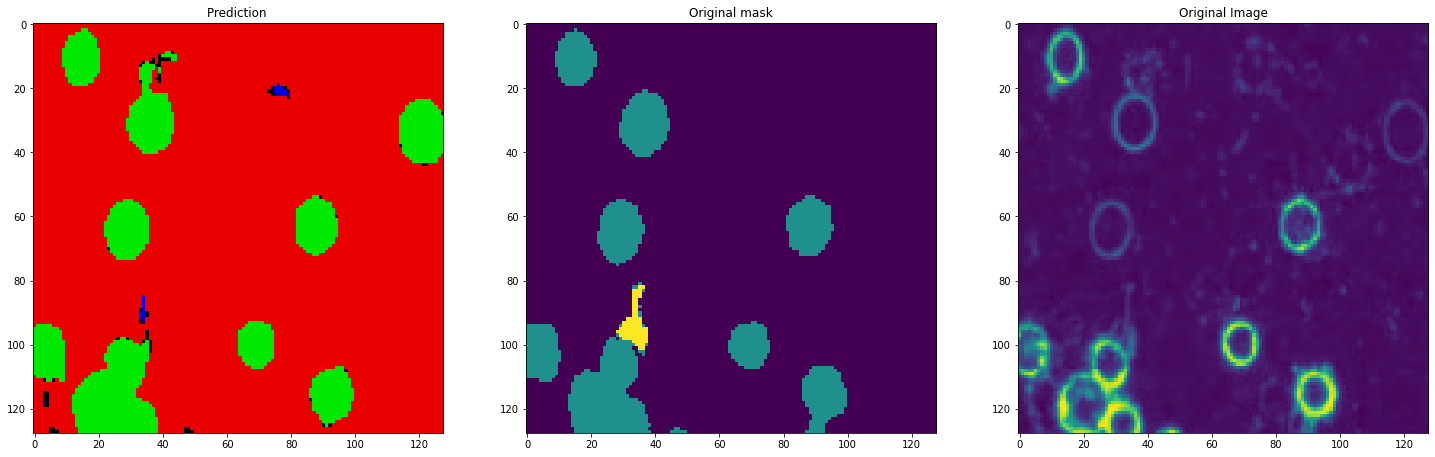

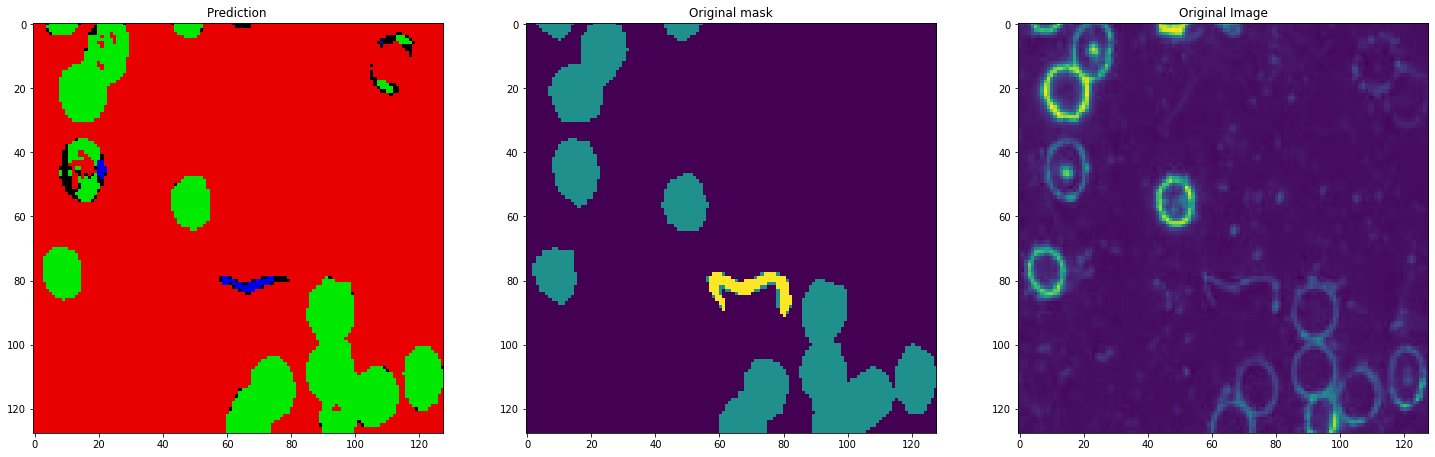

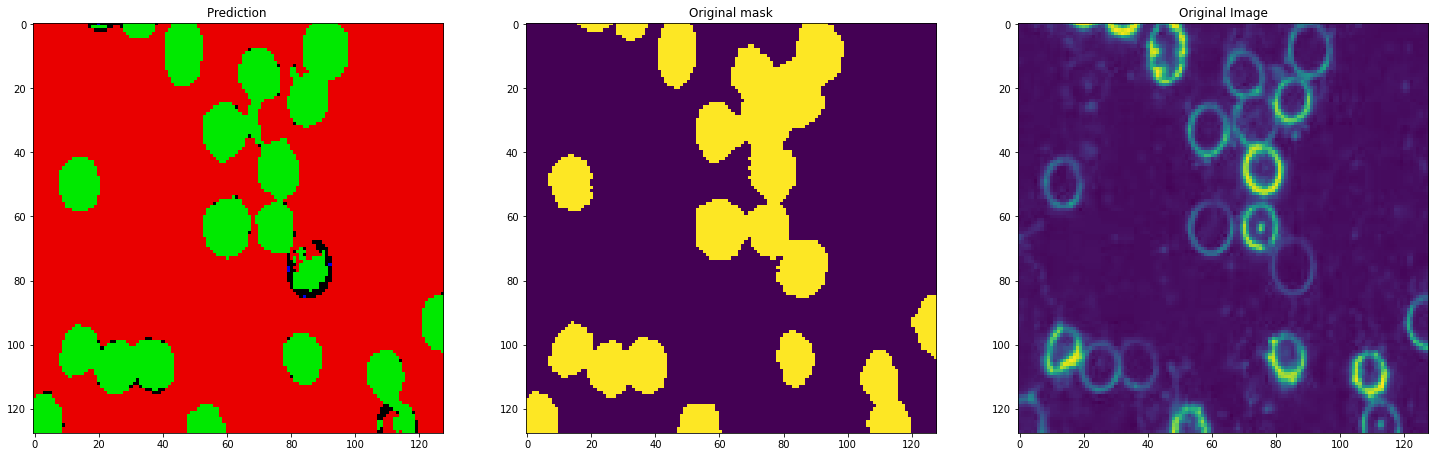

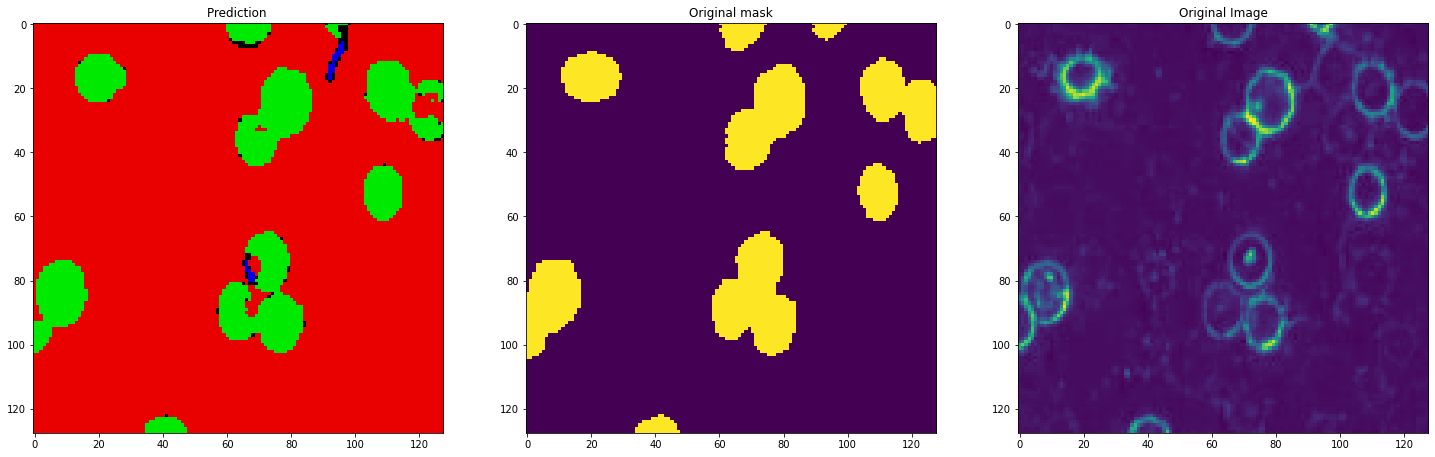

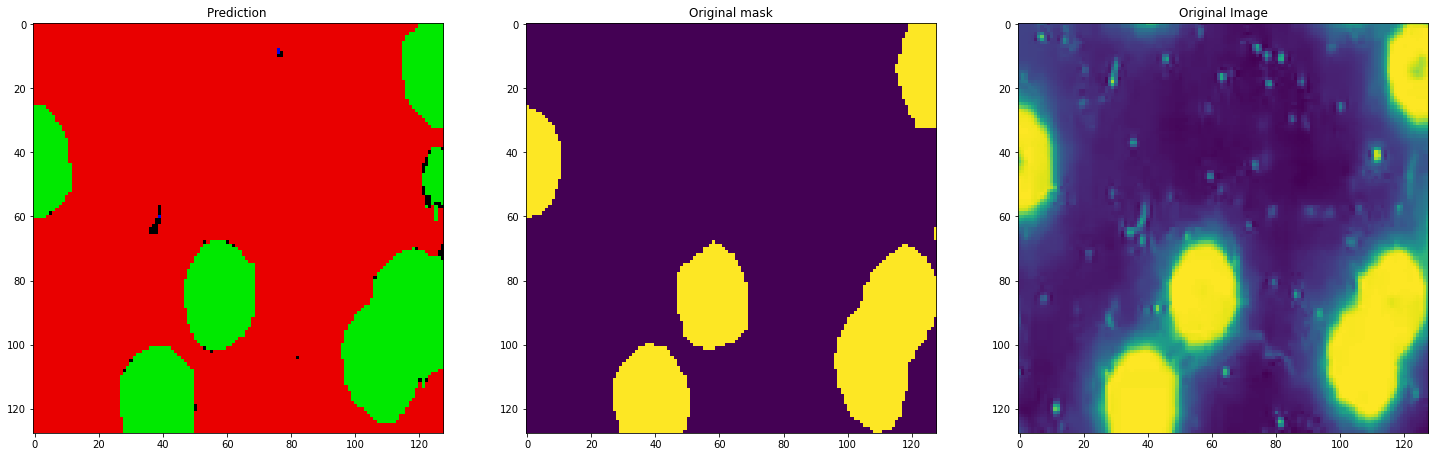

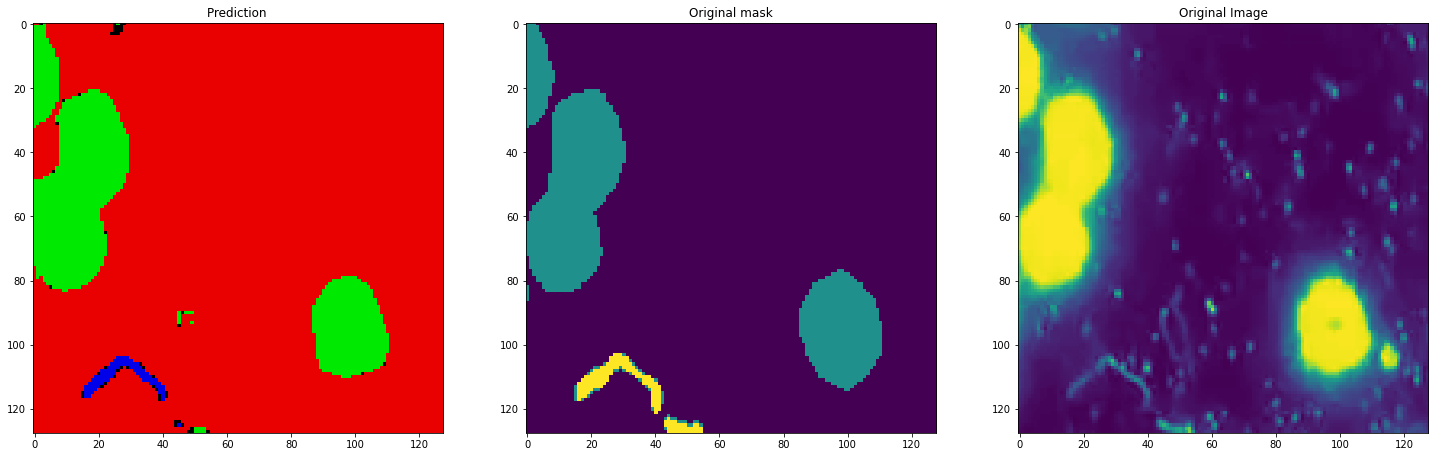

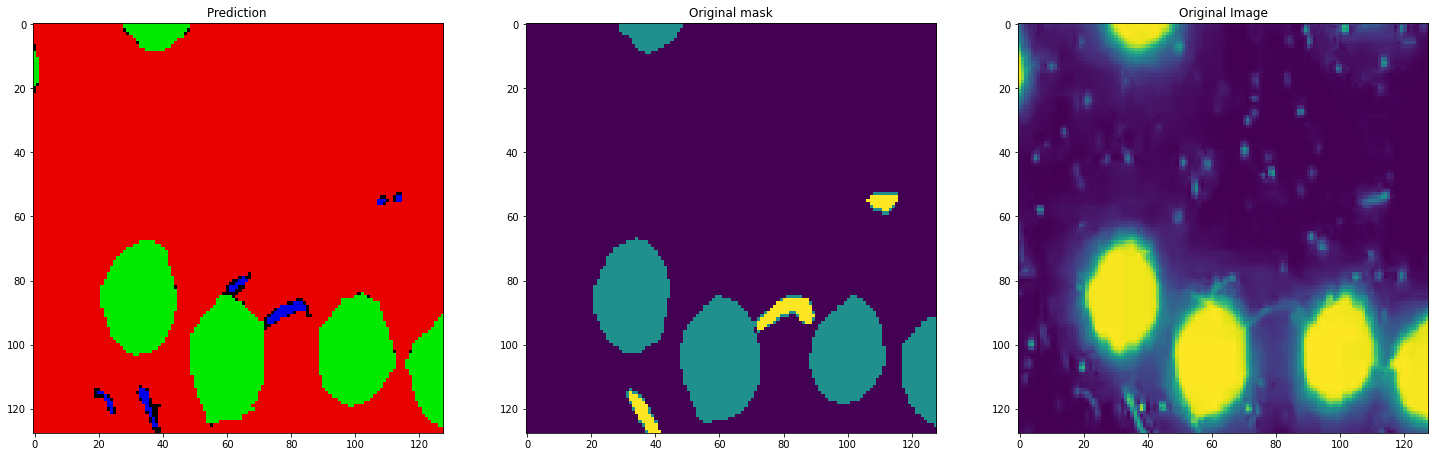

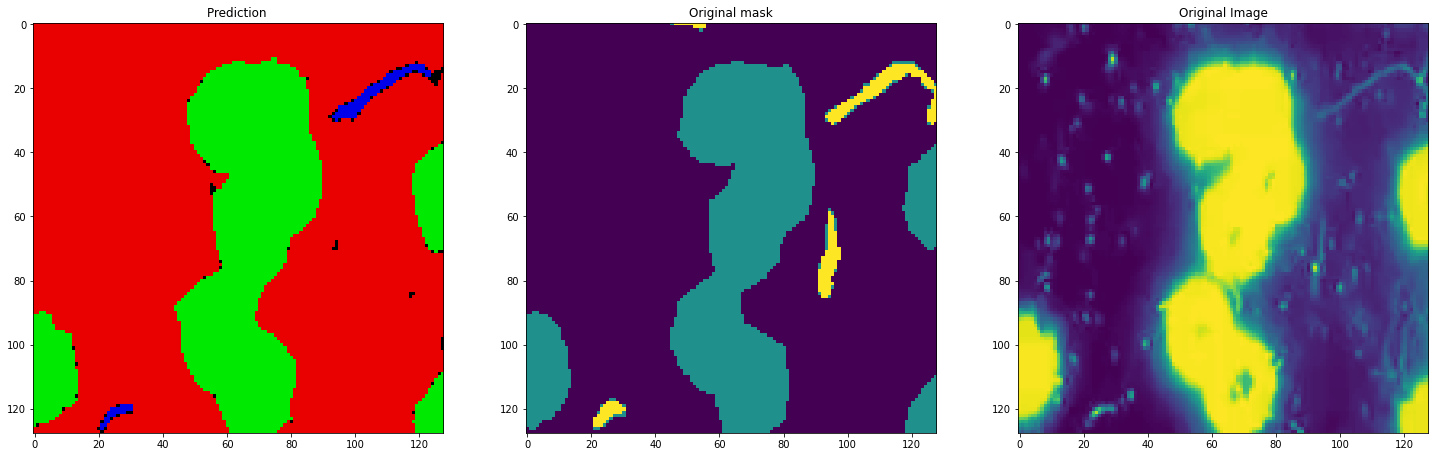

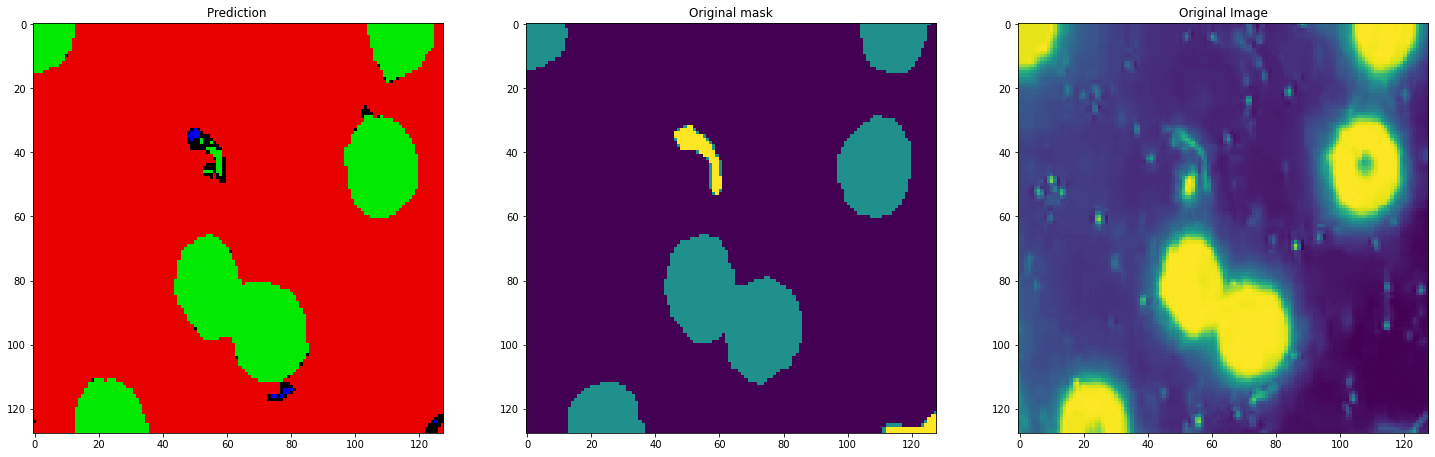

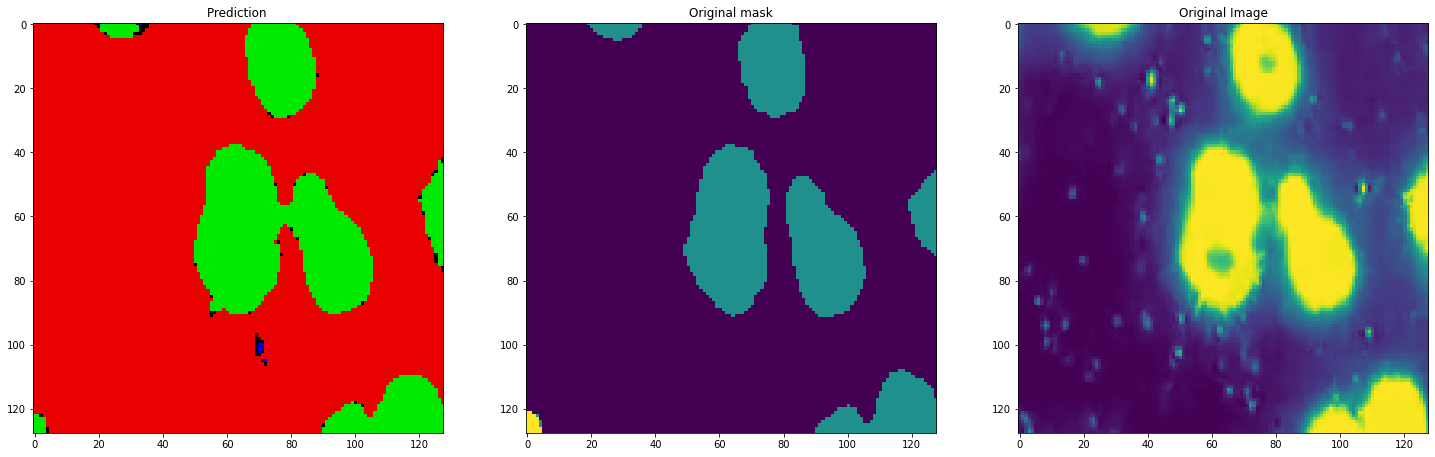

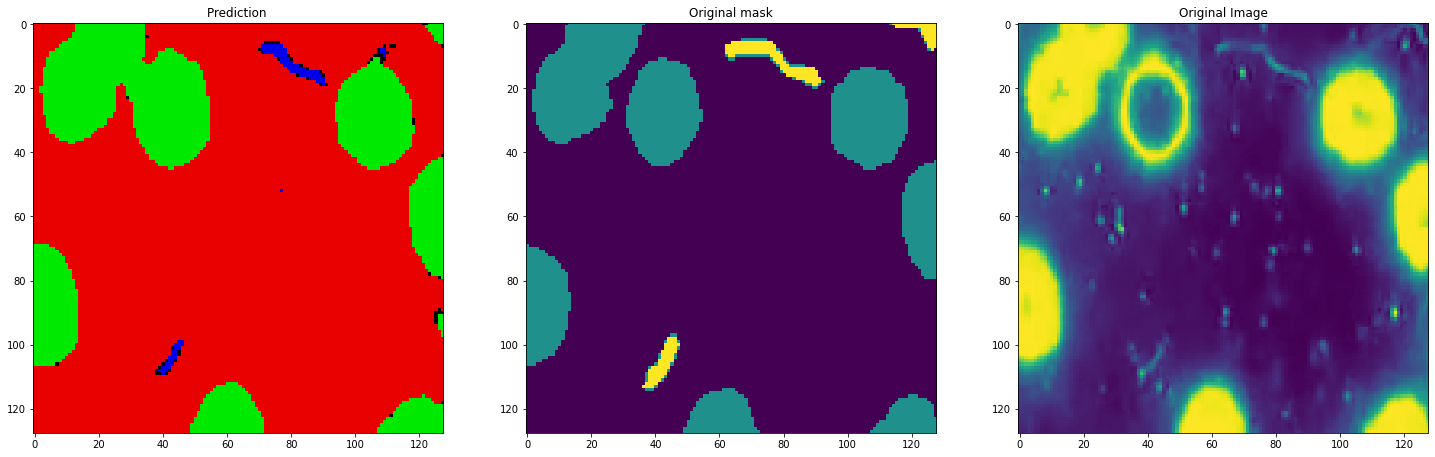

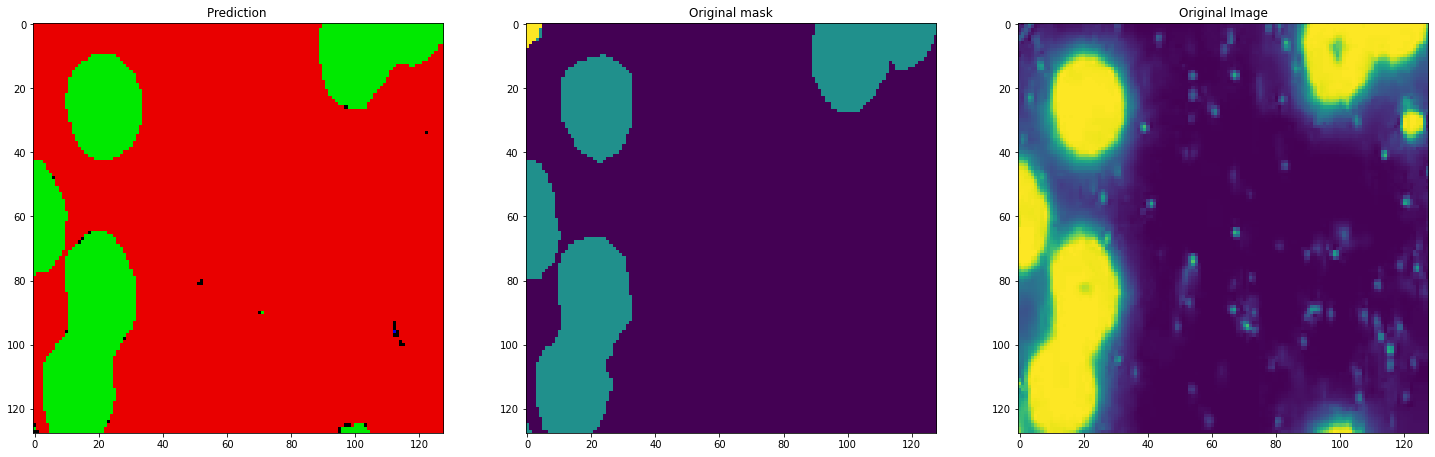

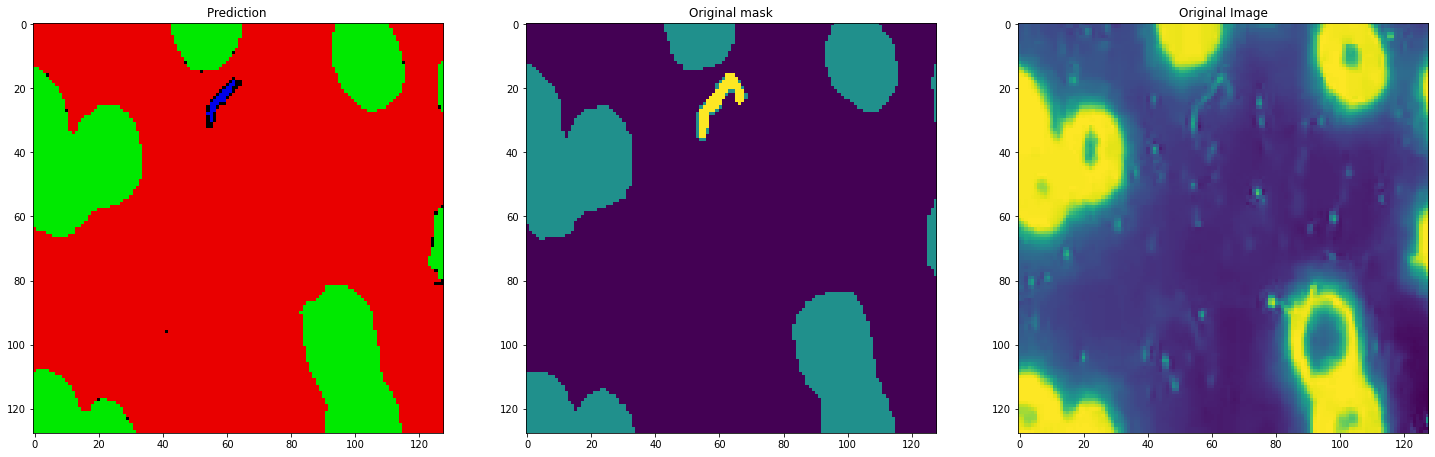

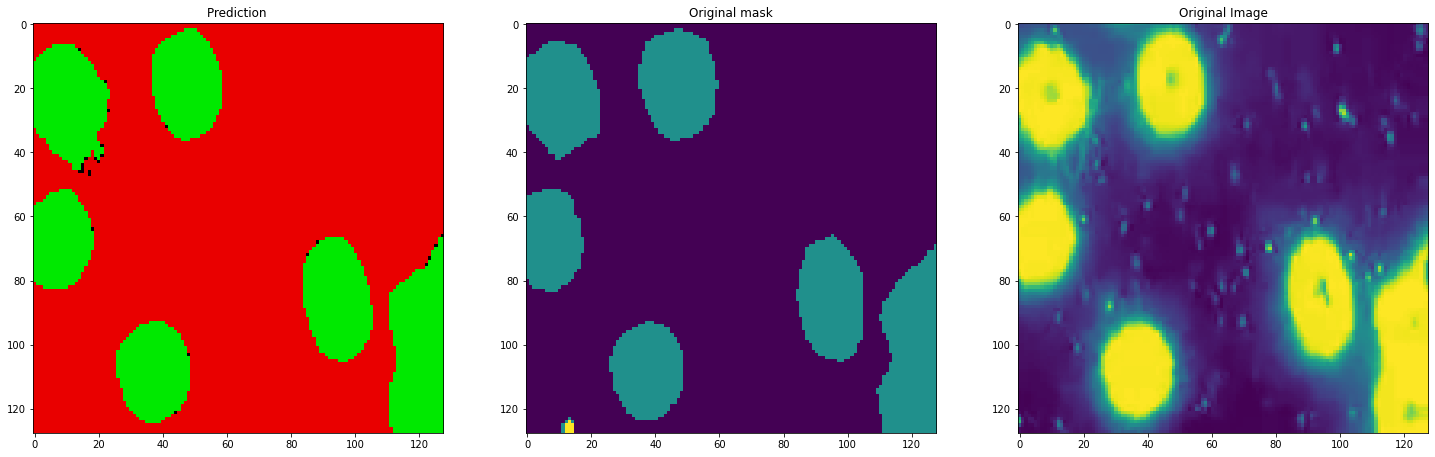

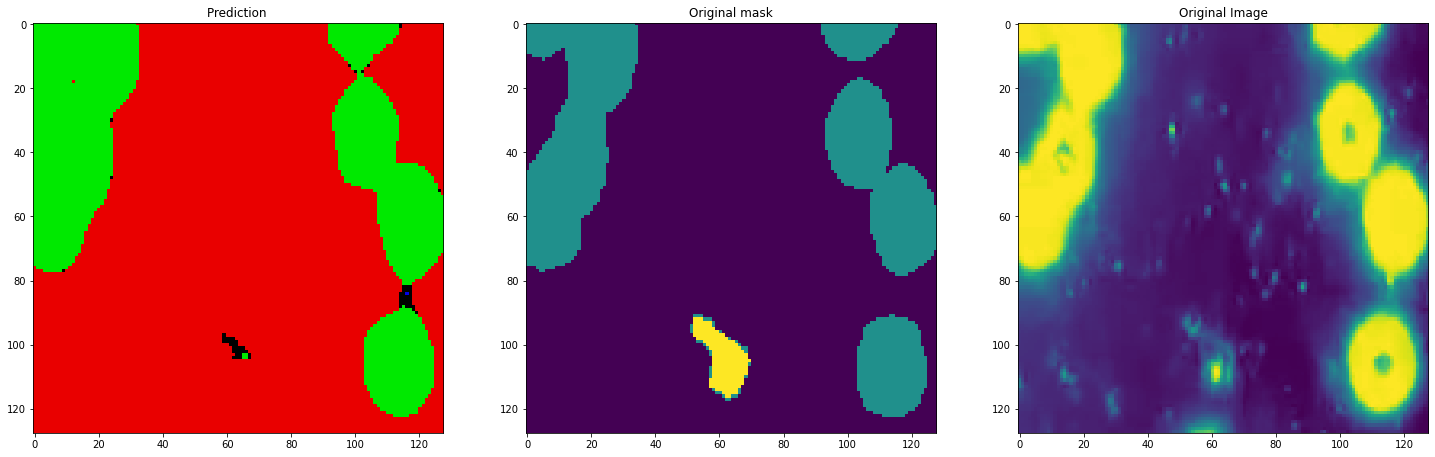

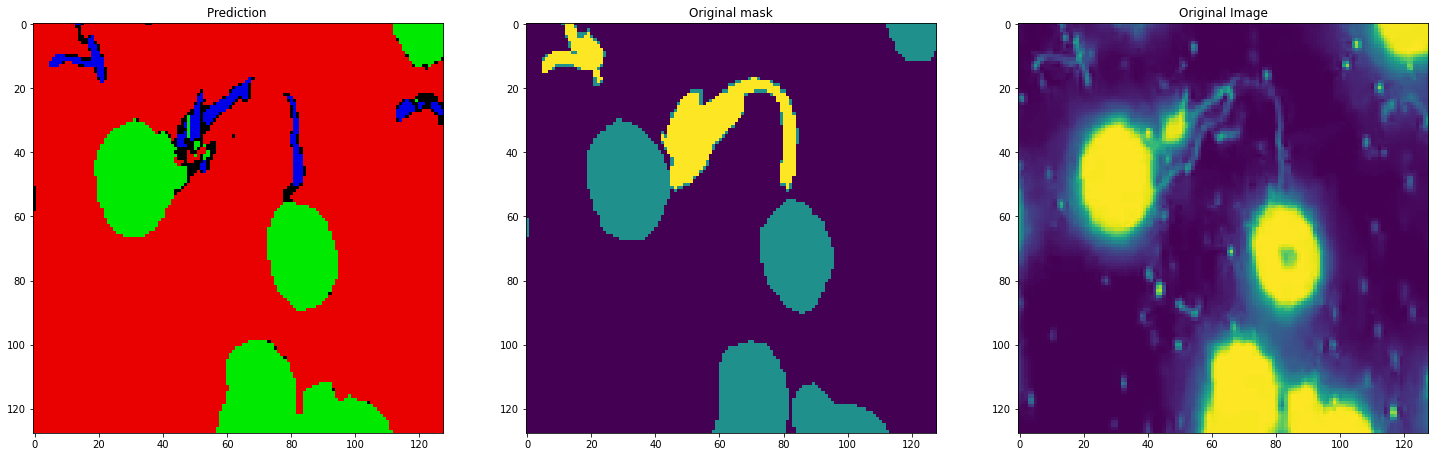

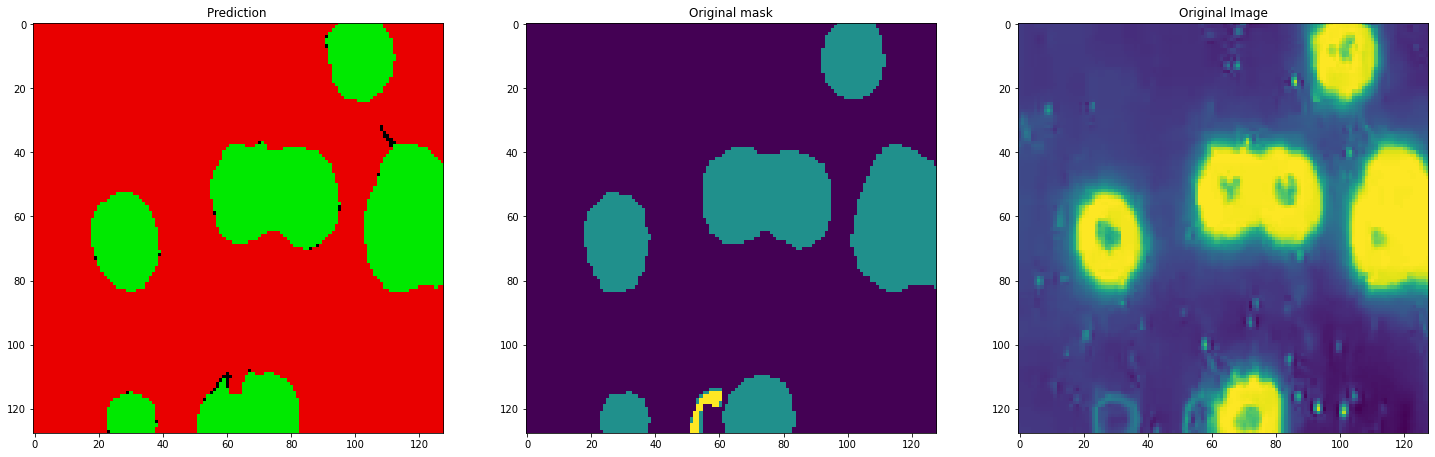

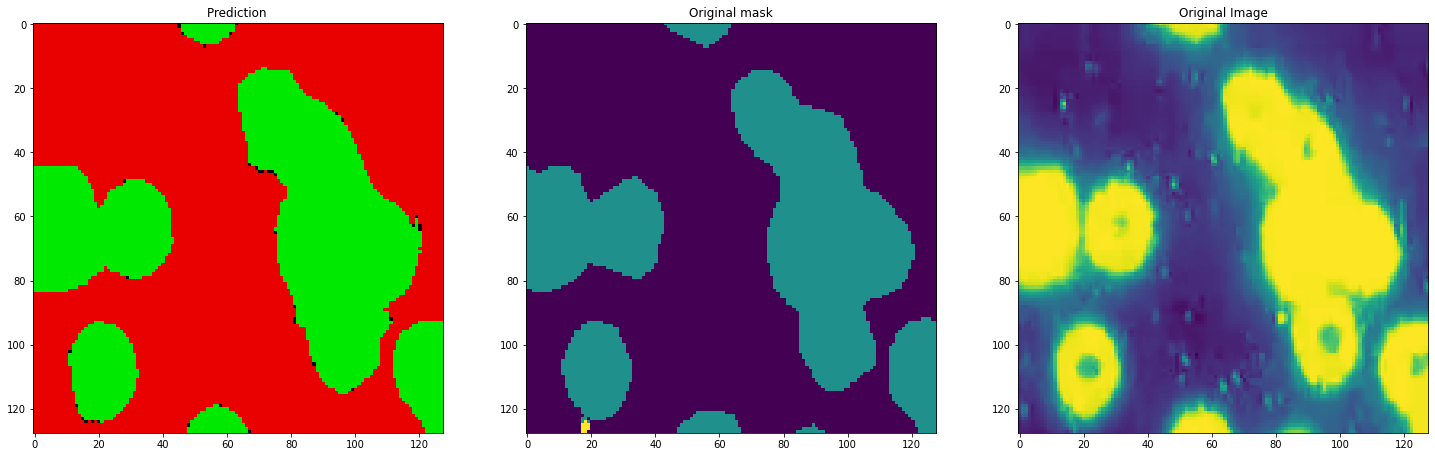

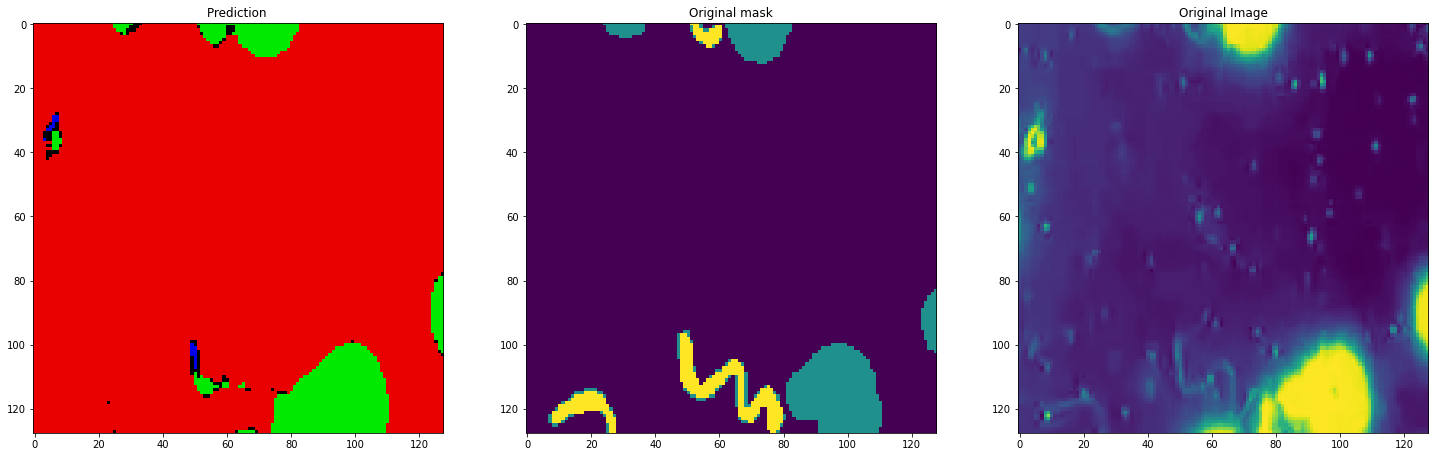

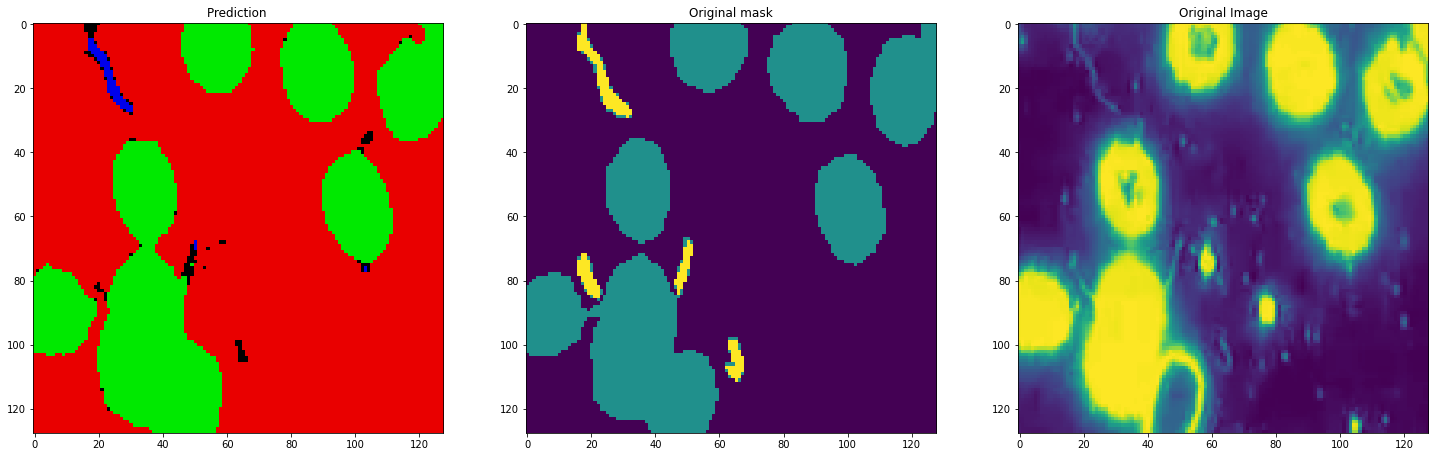

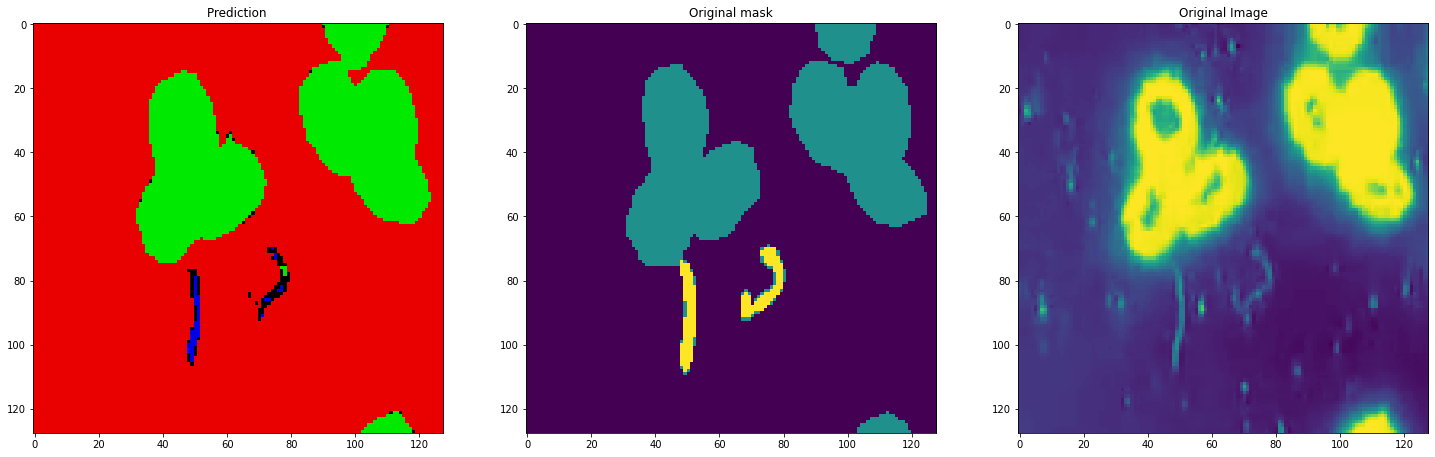

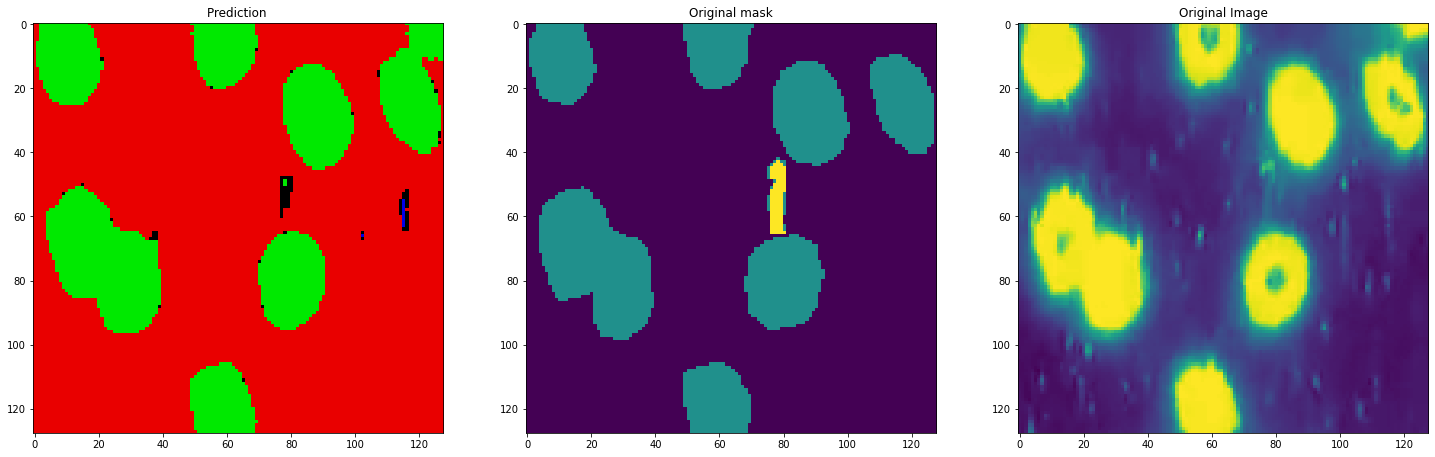

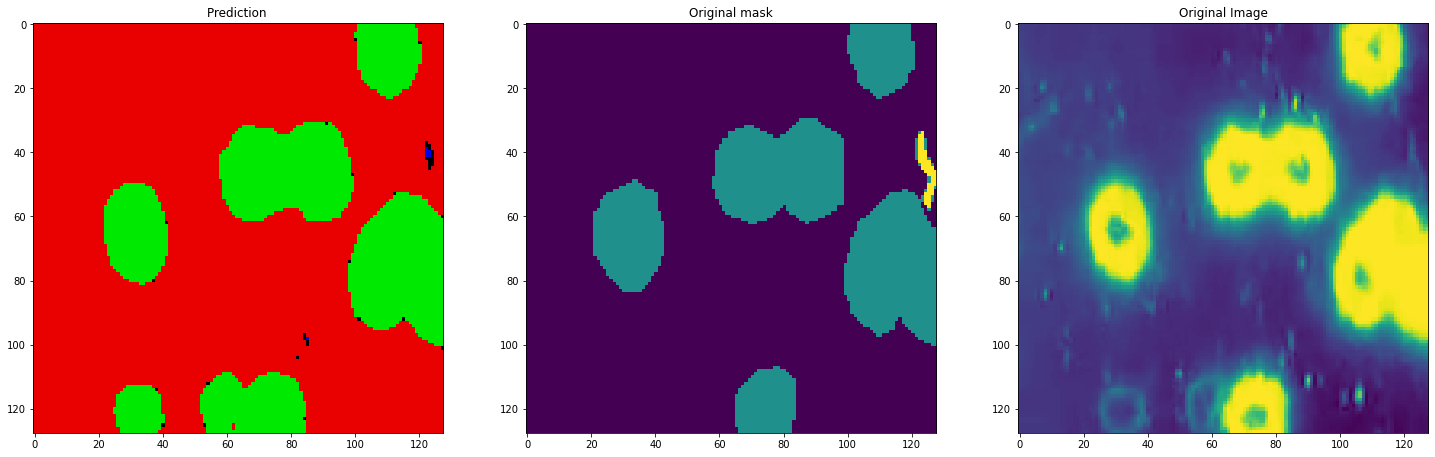

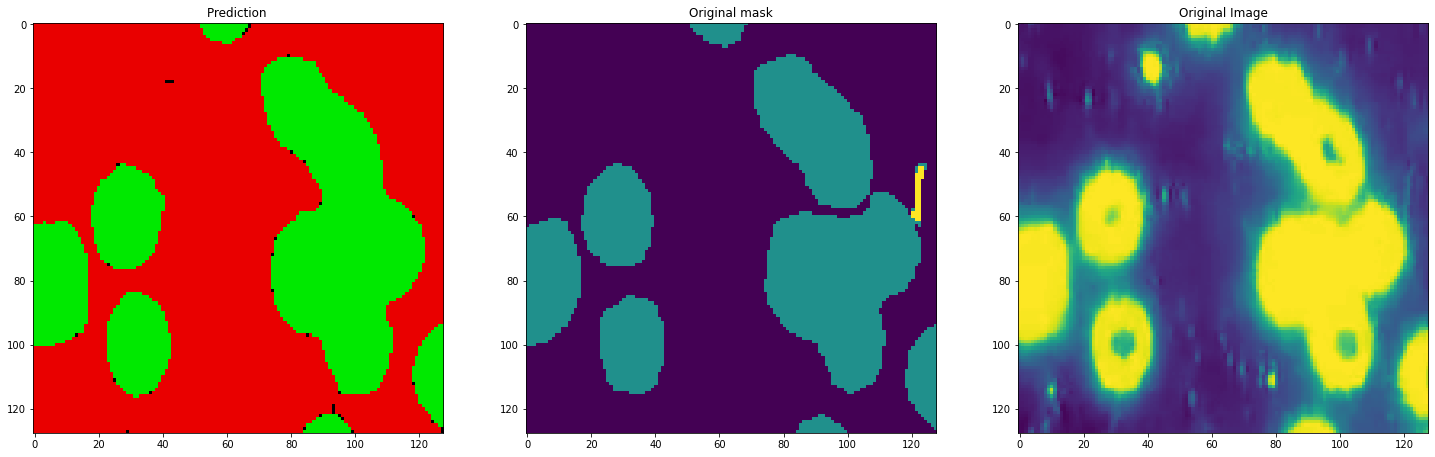

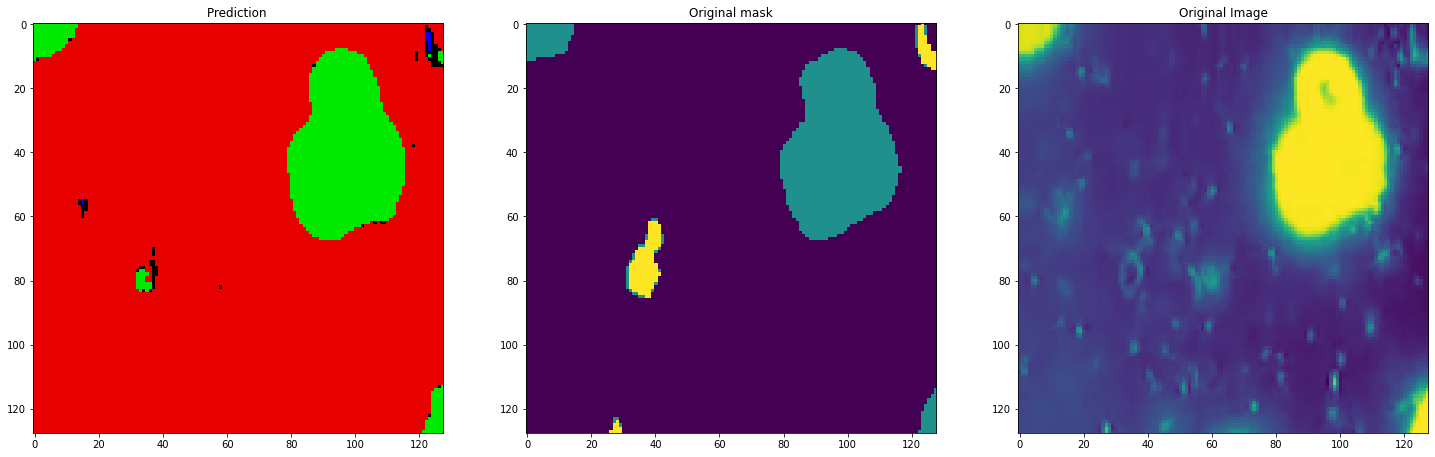

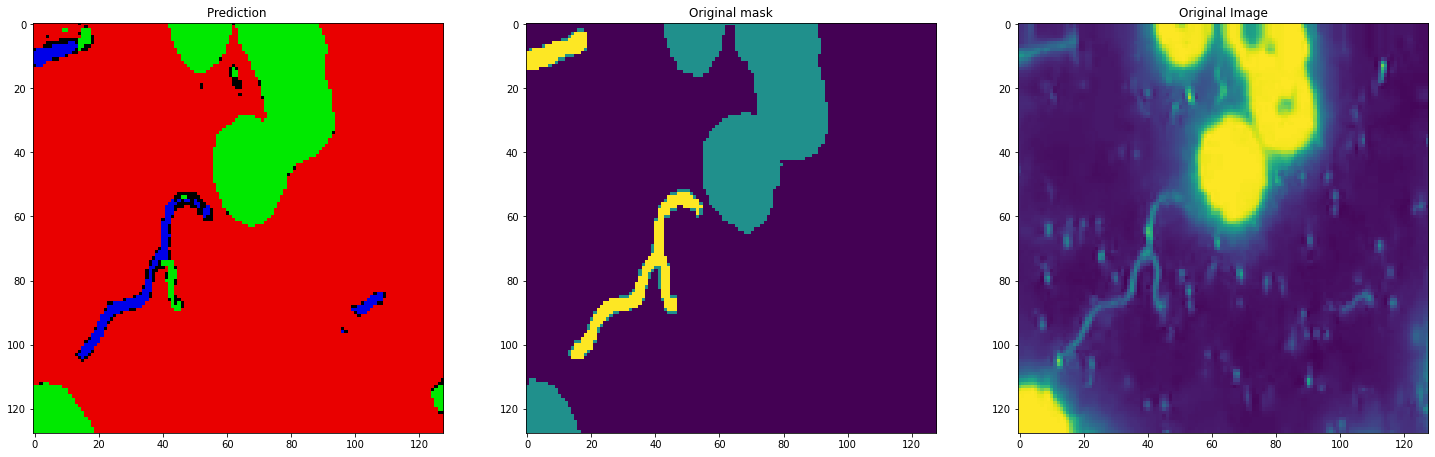

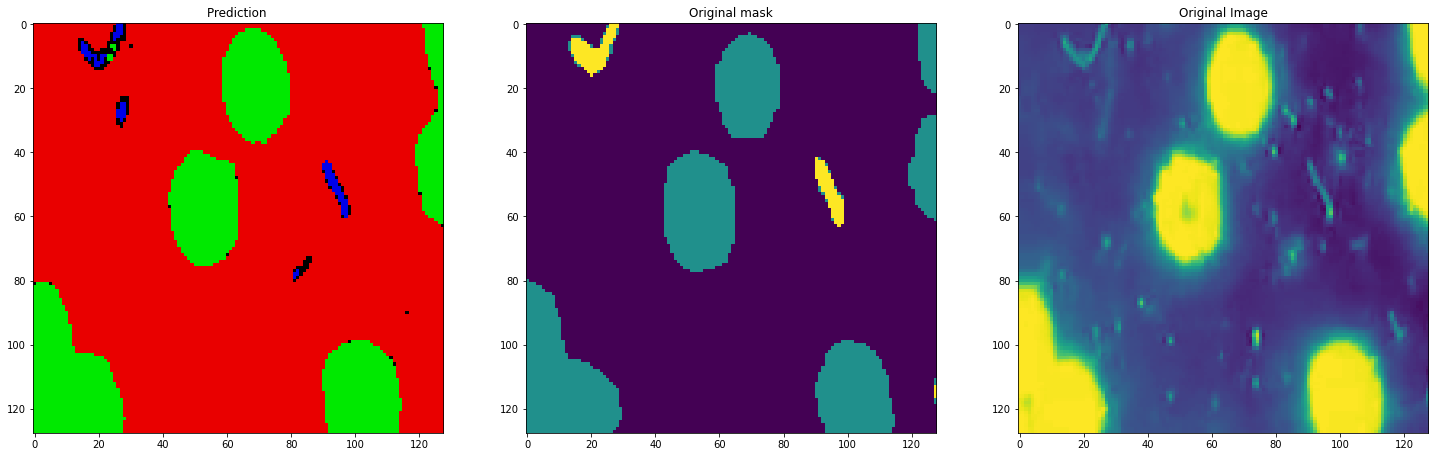

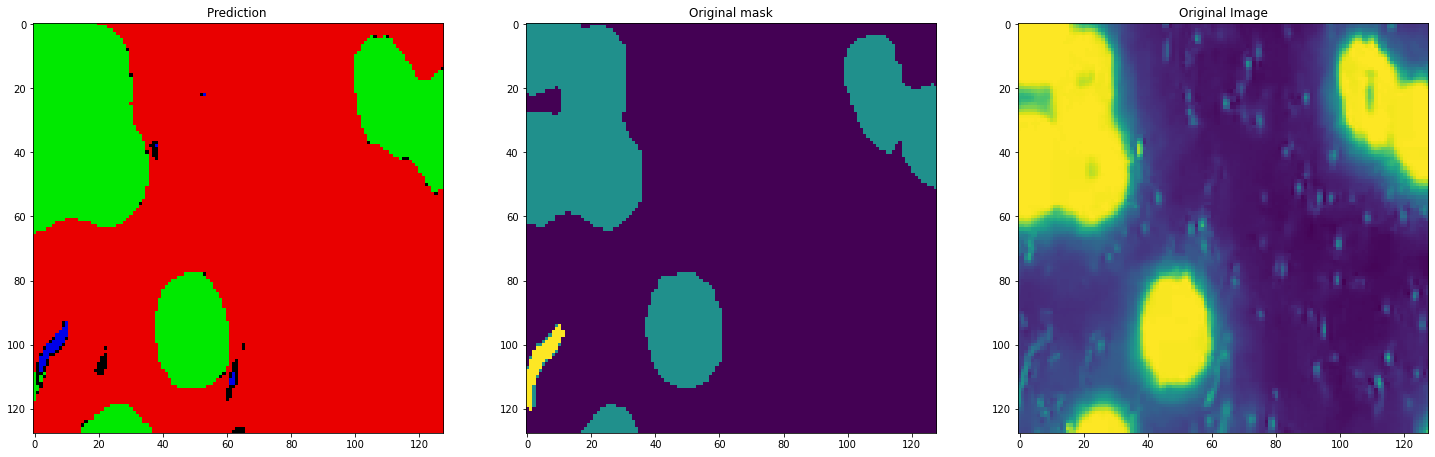

In [ ]:
predicao = model.predict(test_imgs[:50])
for i in range(50):
  
  pred = (predicao[i])
  fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (25,25))

  pred0 = tf.where(pred>0.5,233,0)
  org = test_masks[i][:,:,0]
  img = test_imgs[i][:,:,0]
  ax1.imshow(pred0)
  ax1.set_title('Prediction ')

  ax2.imshow(org)#, cmap = 'binary_r')
  ax2.set_title('Original mask')

  ax3.imshow(img)
  ax3.set_title('Original Image')
  plt.show()

Preparation of the images from the video

In [ ]:
#break
images_test_path = Path('/content/drive/MyDrive/Bacterias/unpredicted')

images = list(images_test_path.glob(r'0*.jpg')) # creates a lists with every image
images = sorted(images)
len(images)

500

In [ ]:
new_test = []

for img in images:
  new_test.append(read(img))
len(new_test)  

500

In [ ]:
# for img in new_test[0:10]:
#   plt.axis('off')
#   plt.imshow(img)
#   plt.show() 

In [ ]:
new_test[0].shape

(288, 384, 3)

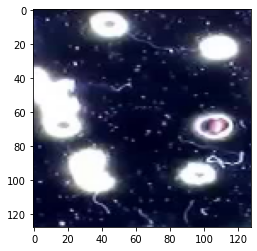

In [ ]:

size = new_test[0].shape
hight = size[0]
width = size[1]

lista = []

for img in new_test:
  new_img = img[:,int(hight/5+140):int(4*hight/5+140),:]
  new_img_resized = cv2.resize(new_img, (128,128))
  lista.append(new_img_resized)

lista = np.array(lista)
lista = lista.reshape((lista.shape[0], lista.shape[1], lista.shape[2],3))
plt.imshow(lista[0])

In [ ]:
# for img in lista[0:50]:
#   plt.imshow(img[:,:,0])
#   plt.show()

In [ ]:
lista[0].shape

(128, 128, 3)

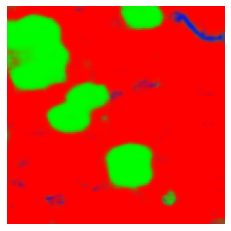

In [ ]:
pred_video = model.predict(lista[299:300])
for pred in pred_video:
  plt.axis('off')
  plt.imshow(pred)
  plt.show()
  plt.clf

In [ ]:

pred_video = model.predict(lista[:len(lista)])


In [ ]:
4%10

4

In [ ]:

i = 0
for pred,original in zip(pred_video, lista):
 i+=1
 img, ax0 = plt.subplots(1,1, figsize = (25,25))

 plt.axis('off')
 pred0 = tf.where(pred>0.5,233,0)
 ax0.imshow(pred0)
 #ax1.imshow(original[:,:,0])
 plt.savefig('/content/drive/MyDrive/Bacterias/0{}.jpg' .format(i).zfill(10), bbox_inches='tight')
 plt.clf()
 plt.close()